# EDA-2: Frequency Domain Analysis

Comprehensive frequency-domain analysis of the XJTU-SY bearing dataset.

## Analysis Areas
1. FFT visualization for sample signals
2. Power Spectral Density (PSD) analysis
3. Bearing characteristic frequencies (BPFO, BPFI, BSF, FTF)
4. Band power analysis across degradation stages
5. Frequency content evolution over bearing lifecycle

## Dataset Parameters
- Sampling rate: 25.6 kHz
- Nyquist frequency: 12.8 kHz
- Samples per file: 32,768
- Bearing: LDK UER204
- Operating conditions: 35Hz/12kN, 37.5Hz/11kN, 40Hz/10kN

In [13]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import rfft, rfftfreq

from src.data.loader import XJTUBearingLoader, SAMPLING_RATE, BEARINGS_PER_CONDITION
from src.features.frequency_domain import (
    calculate_bearing_frequencies,
    get_characteristic_frequencies_for_condition,
    compute_fft,
    compute_psd,
    BEARING_GEOMETRY,
    NYQUIST_FREQ
)

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Initialize data loader (use relative path from notebooks directory)
loader = XJTUBearingLoader(data_root='../assets/Data/XJTU-SY_Bearing_Datasets')

print(f"Sampling Rate: {SAMPLING_RATE:,} Hz")
print(f"Nyquist Frequency: {NYQUIST_FREQ:,} Hz")
print(f"Bearing: LDK UER204")
print(f"  - Number of balls: {BEARING_GEOMETRY['n_balls']}")
print(f"  - Ball diameter: {BEARING_GEOMETRY['ball_diameter']} mm")
print(f"  - Pitch diameter: {BEARING_GEOMETRY['pitch_diameter']} mm")

Sampling Rate: 25,600 Hz
Nyquist Frequency: 12,800.0 Hz
Bearing: LDK UER204
  - Number of balls: 8
  - Ball diameter: 7.92 mm
  - Pitch diameter: 34.5 mm


## 1. Sample Signal Loading

Load sample signals from different bearings and conditions for analysis.

In [14]:
# Load sample signals from each condition
# Select one healthy (early), one degrading (mid), one failed (late) file per bearing
sample_bearings = [
    ('35Hz12kN', 'Bearing1_1'),
    ('37.5Hz11kN', 'Bearing2_3'),
    ('40Hz10kN', 'Bearing3_2'),
]

# Load metadata to get file counts
metadata = loader.get_metadata()

# Dictionary to store sample signals
samples = {}

for condition, bearing_id in sample_bearings:
    bearing_meta = metadata[(metadata['condition'] == condition) & 
                            (metadata['bearing_id'] == bearing_id)]
    num_files = len(bearing_meta)
    
    # Select files at 5%, 50%, and 95% of lifecycle
    indices = {
        'healthy': int(num_files * 0.05),
        'degrading': int(num_files * 0.50),
        'failed': int(num_files * 0.95),
    }
    
    samples[f"{condition}_{bearing_id}"] = {
        'condition': condition,
        'bearing_id': bearing_id,
        'num_files': num_files,
        'signals': {}
    }
    
    for stage, idx in indices.items():
        file_path = bearing_meta.iloc[idx]['file_path']
        signal_data = loader.load_file(file_path)
        samples[f"{condition}_{bearing_id}"]['signals'][stage] = {
            'data': signal_data,
            'file_idx': idx,
            'filename': bearing_meta.iloc[idx]['filename']
        }
    
    print(f"Loaded {bearing_id} ({condition}): {num_files} files")
    print(f"  - Healthy (5%): file {indices['healthy']}")
    print(f"  - Degrading (50%): file {indices['degrading']}")
    print(f"  - Failed (95%): file {indices['failed']}")

Loaded Bearing1_1 (35Hz12kN): 123 files
  - Healthy (5%): file 6
  - Degrading (50%): file 61
  - Failed (95%): file 116
Loaded Bearing2_3 (37.5Hz11kN): 533 files
  - Healthy (5%): file 26
  - Degrading (50%): file 266
  - Failed (95%): file 506
Loaded Bearing3_2 (40Hz10kN): 2496 files
  - Healthy (5%): file 124
  - Degrading (50%): file 1248
  - Failed (95%): file 2371


## 2. FFT Visualization

Visualize the Fast Fourier Transform (FFT) magnitude spectrum for sample signals. The FFT shows the frequency content of the vibration signal up to the Nyquist frequency (12.8 kHz).

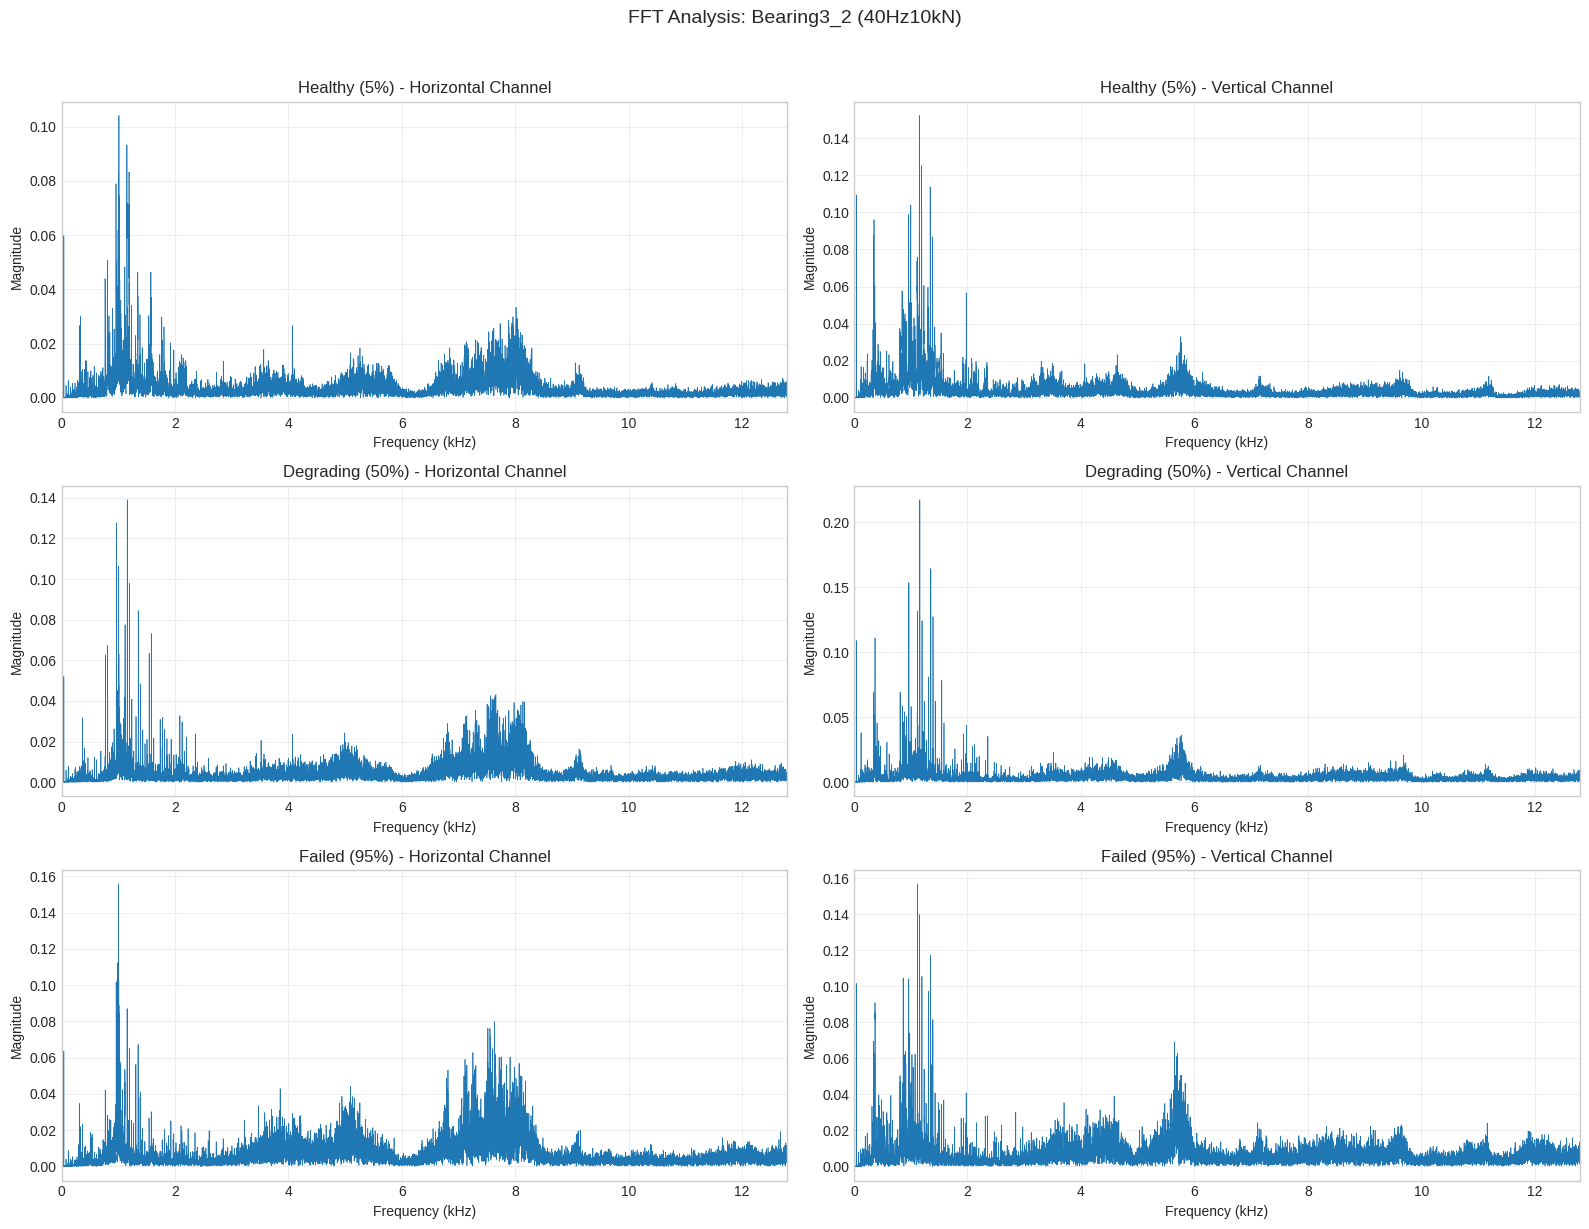

In [15]:
def plot_fft(signal_data, sampling_rate=SAMPLING_RATE, title="FFT Magnitude Spectrum", ax=None):
    """Plot FFT magnitude spectrum."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 5))
    
    freqs, magnitudes = compute_fft(signal_data, sampling_rate)
    
    ax.plot(freqs / 1000, magnitudes, linewidth=0.5)  # Convert to kHz
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Magnitude')
    #ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlim(0, NYQUIST_FREQ / 1000)
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot FFT for healthy, degrading, and failed signals from one bearing
sample_key = '40Hz10kN_Bearing3_2'
sample = samples[sample_key]    

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for row, stage in enumerate(['healthy', 'degrading', 'failed']):
    signal_data = sample['signals'][stage]['data']
    file_idx = sample['signals'][stage]['file_idx']
    lifecycle_pct = file_idx / sample['num_files'] * 100
    
    # Horizontal channel
    plot_fft(signal_data[:, 0], title=f"{stage.title()} ({lifecycle_pct:.0f}%) - Horizontal Channel", 
             ax=axes[row, 0])
    
    # Vertical channel
    plot_fft(signal_data[:, 1], title=f"{stage.title()} ({lifecycle_pct:.0f}%) - Vertical Channel", 
             ax=axes[row, 1])

plt.suptitle(f"FFT Analysis: {sample['bearing_id']} ({sample['condition']})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

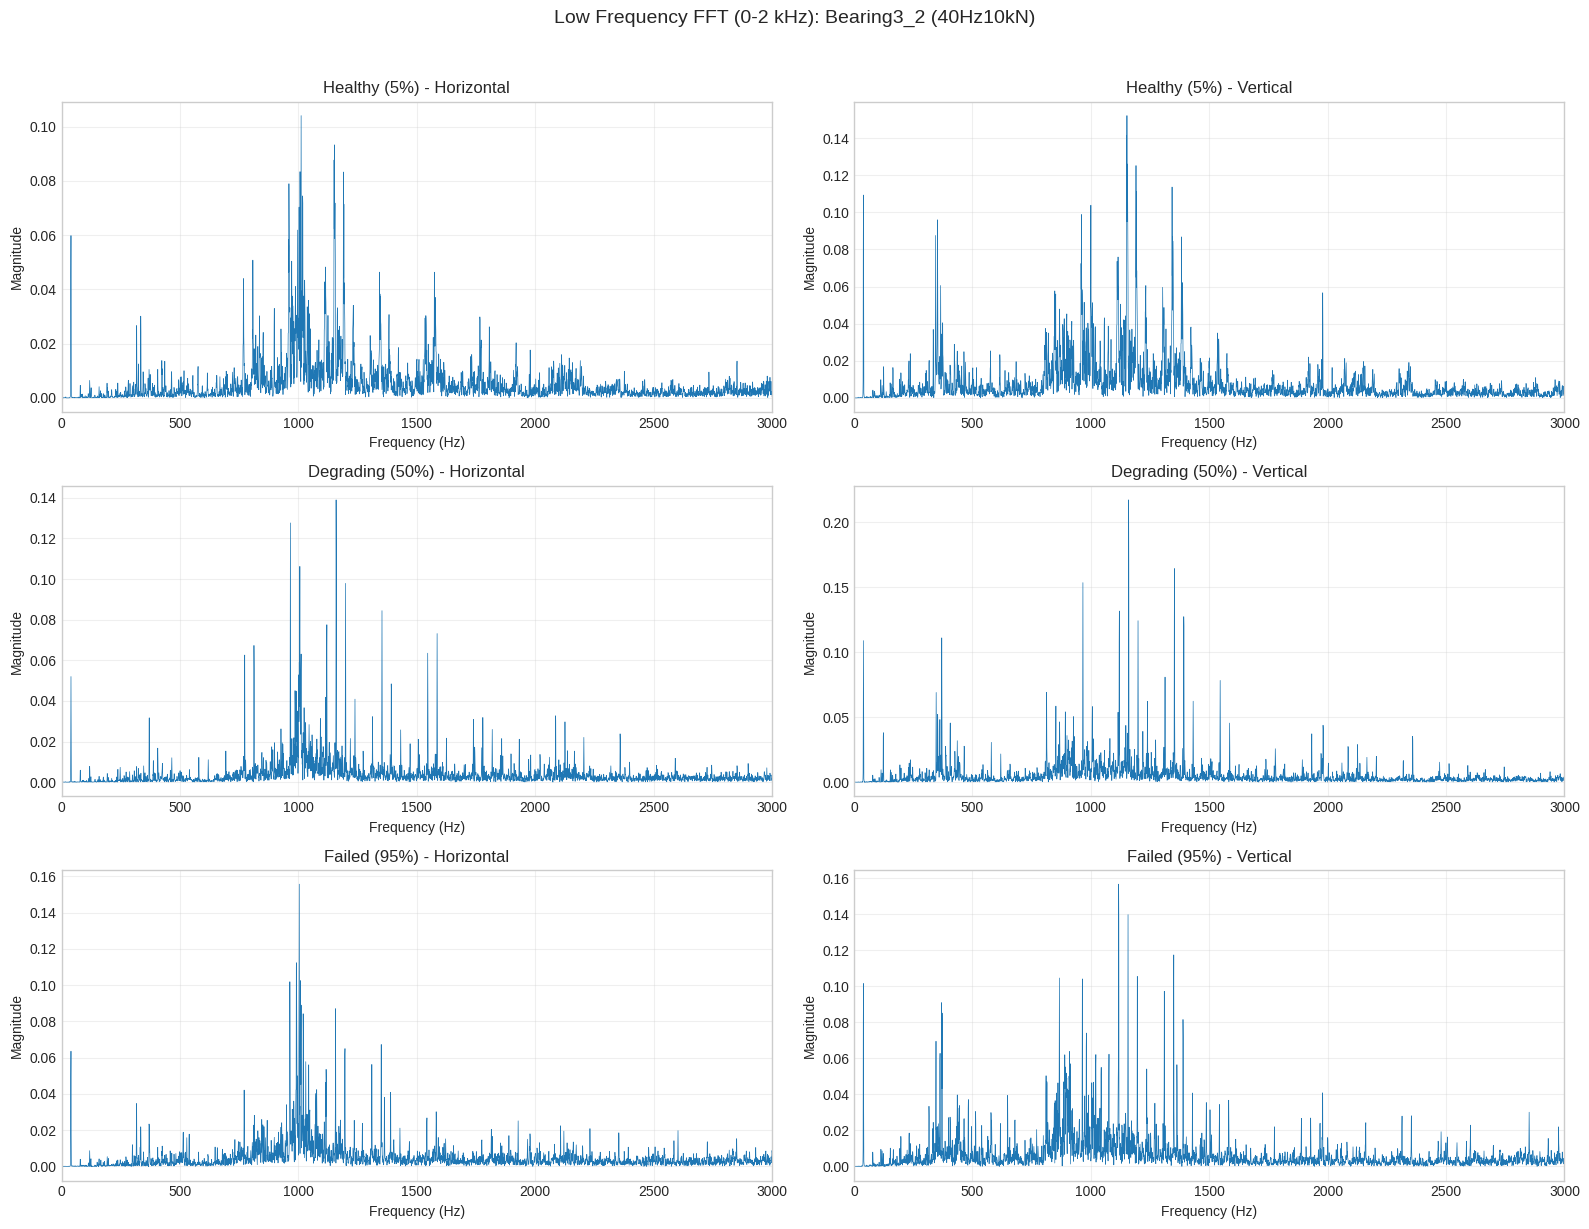

In [16]:
# Zoomed FFT - focus on low frequency range (0-2 kHz) where bearing faults typically manifest
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for row, stage in enumerate(['healthy', 'degrading', 'failed']):
    signal_data = sample['signals'][stage]['data']
    file_idx = sample['signals'][stage]['file_idx']
    lifecycle_pct = file_idx / sample['num_files'] * 100
    
    for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
        freqs, magnitudes = compute_fft(signal_data[:, channel])
        
        ax = axes[row, col]
        ax.plot(freqs, magnitudes, linewidth=0.5)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Magnitude')
        #ax.set_yscale('log')
        ax.set_title(f"{stage.title()} ({lifecycle_pct:.0f}%) - {channel_name}")
        ax.set_xlim(0, 3000)  # Focus on 0-3 kHz
        ax.grid(True, alpha=0.3)

plt.suptitle(f"Low Frequency FFT (0-2 kHz): {sample['bearing_id']} ({sample['condition']})", 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

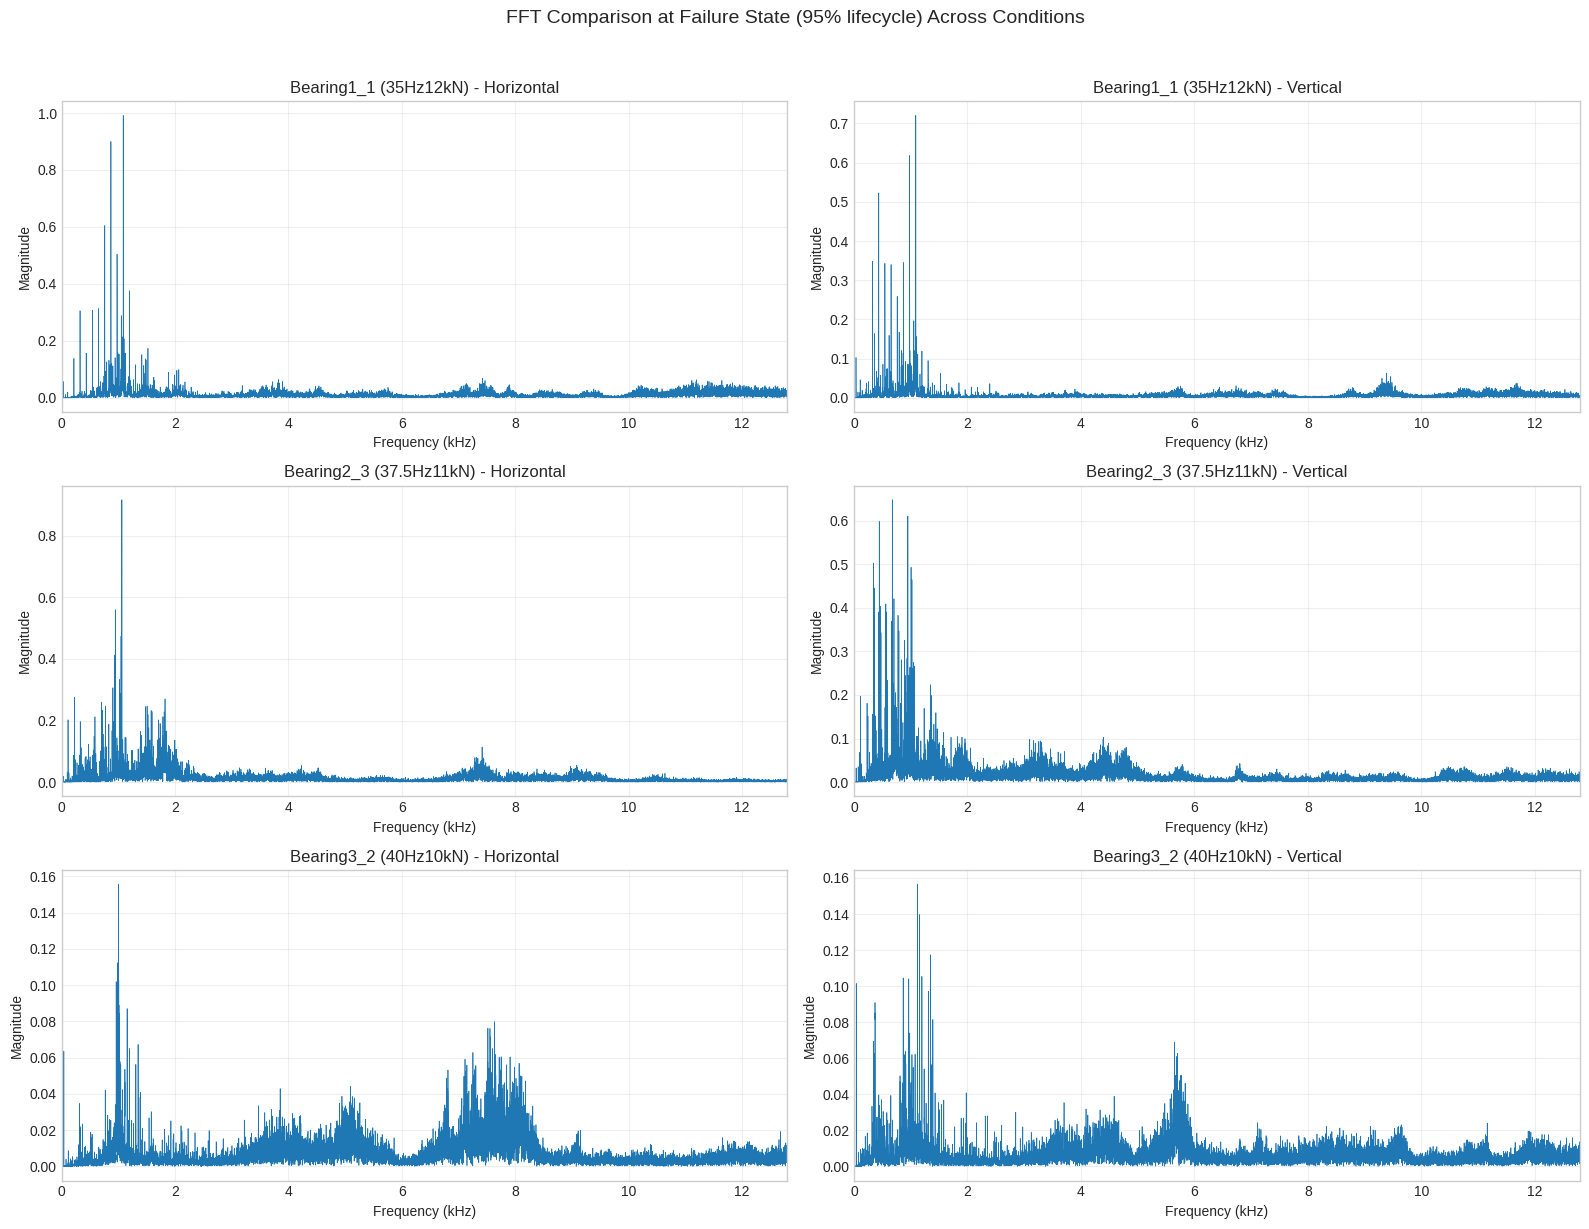

In [17]:
# Compare FFT across conditions at failed state
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for row, (sample_key, sample) in enumerate(samples.items()):
    signal_data = sample['signals']['failed']['data']
    
    for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
        freqs, magnitudes = compute_fft(signal_data[:, channel])
        
        ax = axes[row, col]
        ax.plot(freqs / 1000, magnitudes, linewidth=0.5)
        ax.set_xlabel('Frequency (kHz)')
        ax.set_ylabel('Magnitude')
        ax.set_title(f"{sample['bearing_id']} ({sample['condition']}) - {channel_name}")
        ax.set_xlim(0, NYQUIST_FREQ / 1000)
        ax.grid(True, alpha=0.3)

plt.suptitle("FFT Comparison at Failure State (95% lifecycle) Across Conditions", 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Power Spectral Density (PSD) Analysis

PSD provides a more robust estimate of the power distribution across frequencies using Welch's method, which reduces noise compared to a simple FFT.

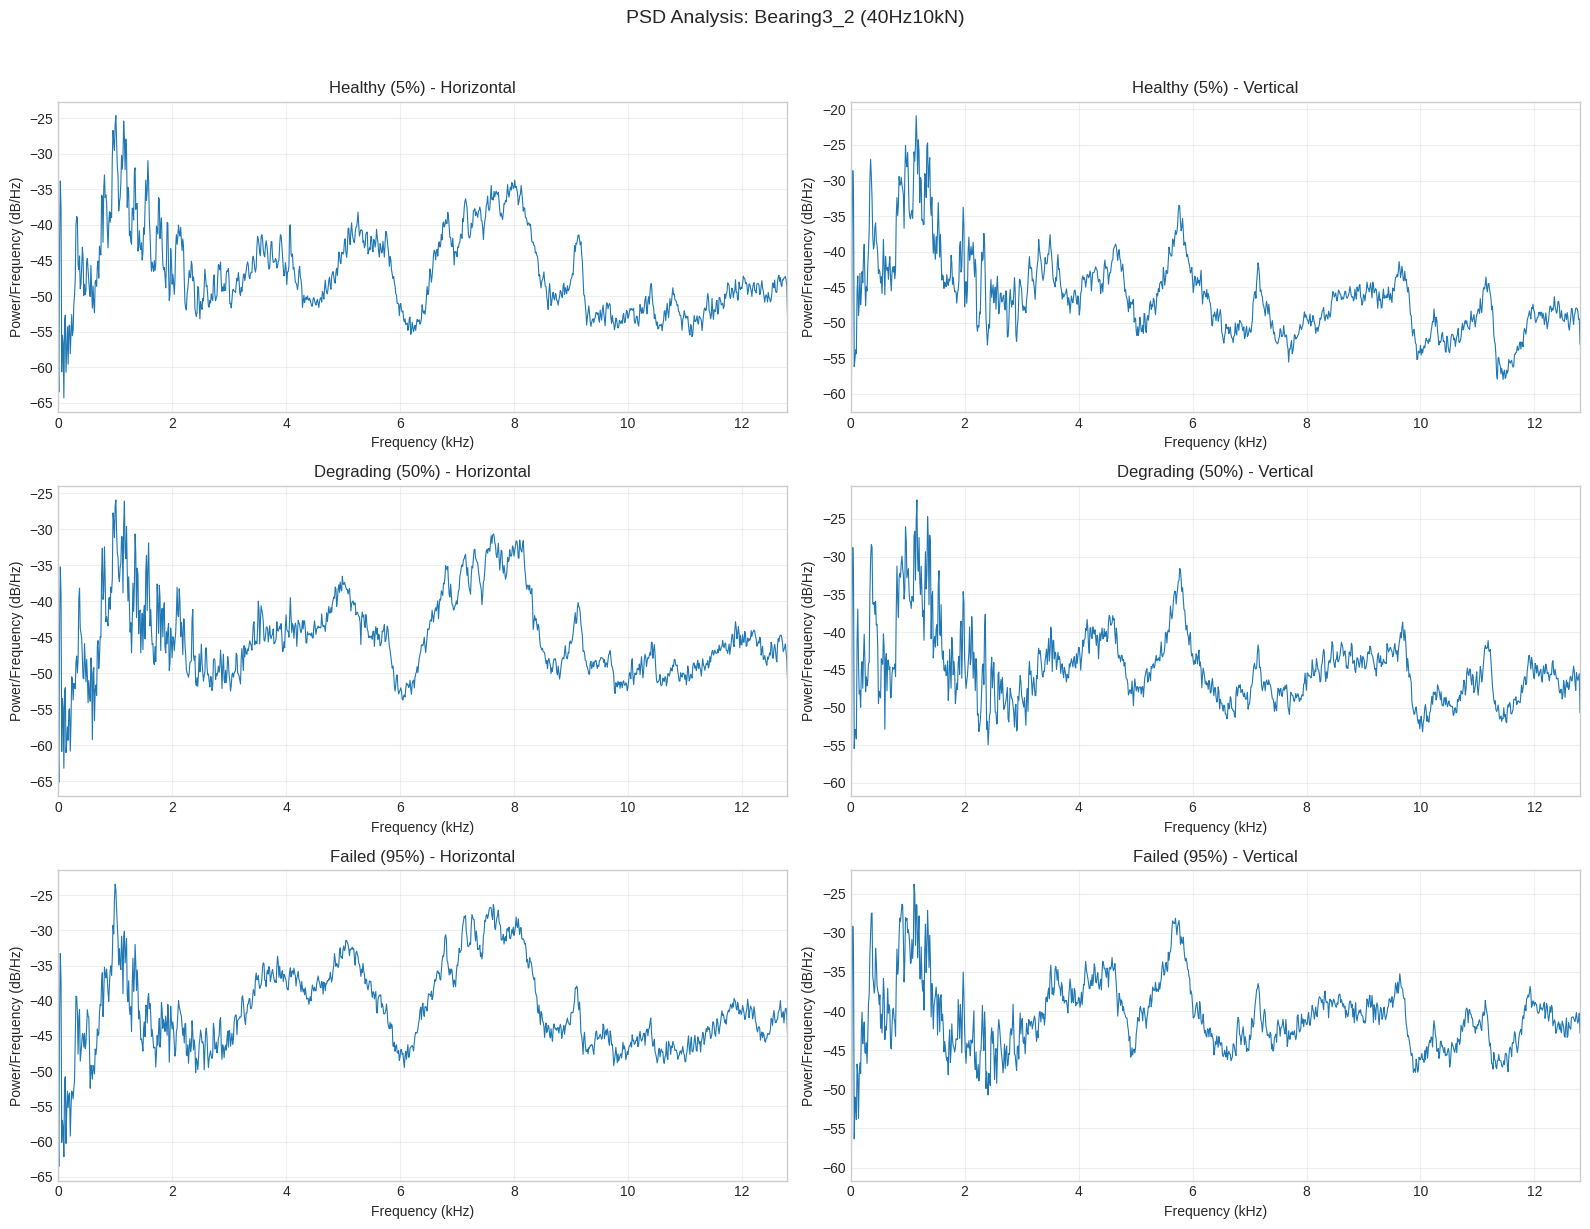

In [18]:
def plot_psd(signal_data, sampling_rate=SAMPLING_RATE, nperseg=2048, 
             title="Power Spectral Density", ax=None, log_scale=True):
    """Plot Power Spectral Density using Welch's method."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 5))
    
    freqs, psd = signal.welch(signal_data, fs=sampling_rate, nperseg=nperseg)
    
    if log_scale:
        psd_db = 10 * np.log10(psd + 1e-10)  # Convert to dB
        ax.plot(freqs / 1000, psd_db, linewidth=0.8)
        ax.set_ylabel('Power/Frequency (dB/Hz)')
    else:
        ax.plot(freqs / 1000, psd, linewidth=0.8)
        ax.set_ylabel('Power/Frequency (V²/Hz)')
    
    ax.set_xlabel('Frequency (kHz)')
    ax.set_title(title)
    ax.set_xlim(0, NYQUIST_FREQ / 1000)
    ax.grid(True, alpha=0.3)
    
    return ax, freqs, psd

# Plot PSD for lifecycle stages
sample_key = '40Hz10kN_Bearing3_2'
sample = samples[sample_key]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for row, stage in enumerate(['healthy', 'degrading', 'failed']):
    signal_data = sample['signals'][stage]['data']
    file_idx = sample['signals'][stage]['file_idx']
    lifecycle_pct = file_idx / sample['num_files'] * 100
    
    # Horizontal channel
    plot_psd(signal_data[:, 0], title=f"{stage.title()} ({lifecycle_pct:.0f}%) - Horizontal", 
             ax=axes[row, 0])
    
    # Vertical channel
    plot_psd(signal_data[:, 1], title=f"{stage.title()} ({lifecycle_pct:.0f}%) - Vertical", 
             ax=axes[row, 1])

plt.suptitle(f"PSD Analysis: {sample['bearing_id']} ({sample['condition']})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

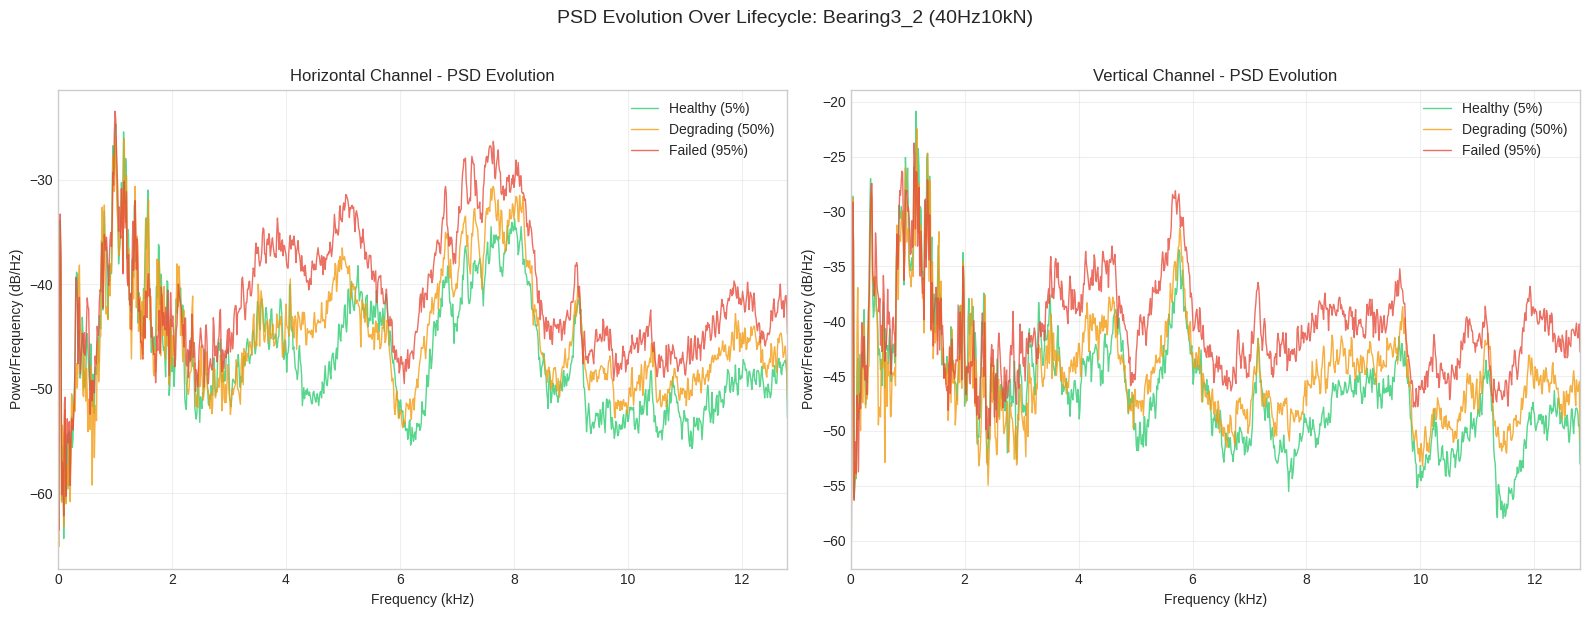

In [19]:
# Overlay PSD at different lifecycle stages
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = {'healthy': '#2ecc71', 'degrading': '#f39c12', 'failed': '#e74c3c'}
labels = {'healthy': 'Healthy (5%)', 'degrading': 'Degrading (50%)', 'failed': 'Failed (95%)'}

for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
    ax = axes[col]
    
    for stage in ['healthy', 'degrading', 'failed']:
        signal_data = sample['signals'][stage]['data'][:, channel]
        freqs, psd = signal.welch(signal_data, fs=SAMPLING_RATE, nperseg=2048)
        psd_db = 10 * np.log10(psd + 1e-10)
        
        ax.plot(freqs / 1000, psd_db, linewidth=1, color=colors[stage], 
                label=labels[stage], alpha=0.8)
    
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Power/Frequency (dB/Hz)')
    ax.set_title(f'{channel_name} Channel - PSD Evolution')
    ax.set_xlim(0, NYQUIST_FREQ / 1000)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f"PSD Evolution Over Lifecycle: {sample['bearing_id']} ({sample['condition']})", 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

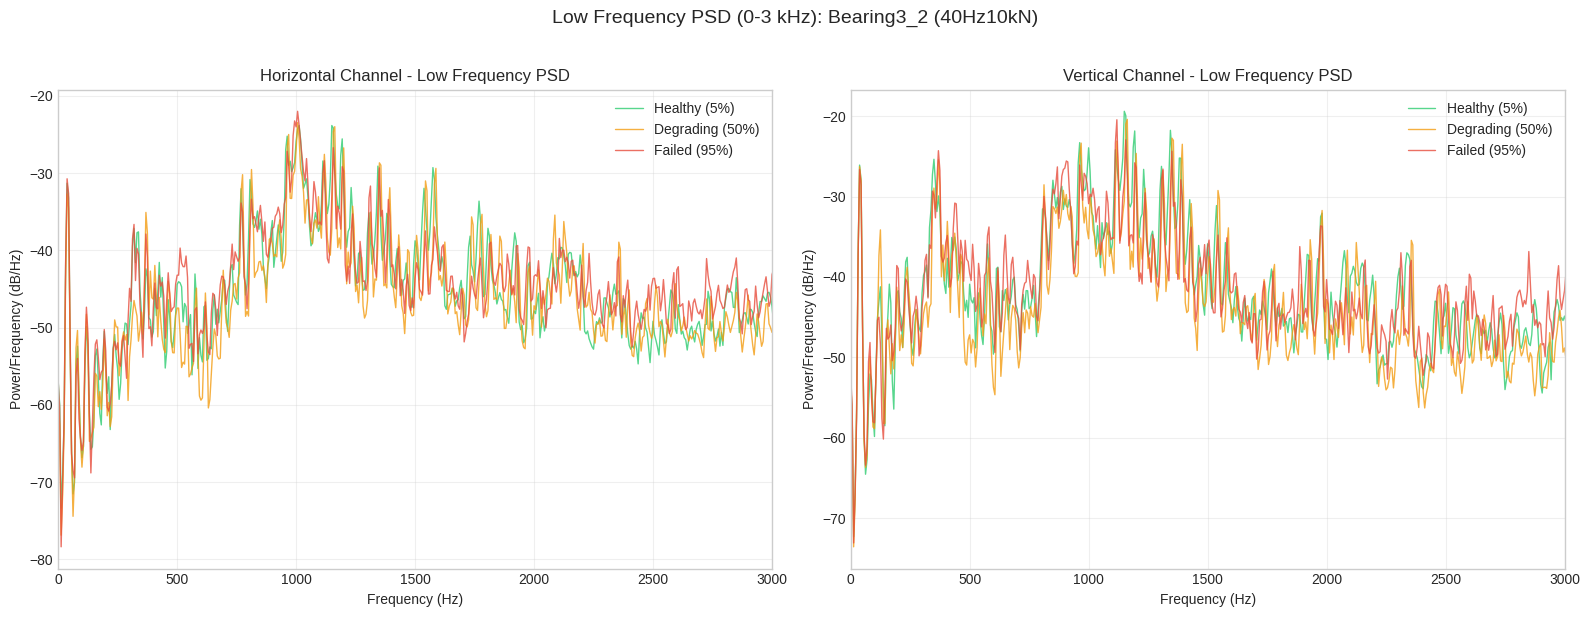

In [20]:
# PSD analysis focused on low frequency range (0-3 kHz)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
    ax = axes[col]
    
    for stage in ['healthy', 'degrading', 'failed']:
        signal_data = sample['signals'][stage]['data'][:, channel]
        freqs, psd = signal.welch(signal_data, fs=SAMPLING_RATE, nperseg=4096)  # Higher resolution
        psd_db = 10 * np.log10(psd + 1e-10)
        
        ax.plot(freqs, psd_db, linewidth=1, color=colors[stage], 
                label=labels[stage], alpha=0.8)
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power/Frequency (dB/Hz)')
    ax.set_title(f'{channel_name} Channel - Low Frequency PSD')
    ax.set_xlim(0, 3000)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f"Low Frequency PSD (0-3 kHz): {sample['bearing_id']} ({sample['condition']})", 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Bearing Characteristic Frequencies

Calculate and visualize the bearing characteristic frequencies for the LDK UER204 bearing:
- **BPFO** (Ball Pass Frequency Outer): Frequency when balls pass over outer race defect
- **BPFI** (Ball Pass Frequency Inner): Frequency when balls pass over inner race defect  
- **BSF** (Ball Spin Frequency): Frequency of ball rotation defect
- **FTF** (Fundamental Train Frequency): Cage rotation frequency

In [21]:
# Calculate characteristic frequencies for each operating condition
conditions = ['35Hz12kN', '37.5Hz11kN', '40Hz10kN']
shaft_frequencies = [35.0, 37.5, 40.0]  # Hz

print("=" * 70)
print("BEARING CHARACTERISTIC FREQUENCIES")
print("=" * 70)
print(f"\nBearing: LDK UER204")
print(f"  - Number of balls (n): {BEARING_GEOMETRY['n_balls']}")
print(f"  - Ball diameter (d): {BEARING_GEOMETRY['ball_diameter']} mm")
print(f"  - Pitch diameter (D): {BEARING_GEOMETRY['pitch_diameter']} mm")
print(f"  - Contact angle: {BEARING_GEOMETRY['contact_angle']}°")

print("\n" + "-" * 70)
char_freq_table = []

for condition, shaft_freq in zip(conditions, shaft_frequencies):
    freqs = get_characteristic_frequencies_for_condition(condition)
    char_freq_table.append({
        'Condition': condition,
        'Shaft (Hz)': shaft_freq,
        'BPFO (Hz)': freqs['bpfo'],
        'BPFI (Hz)': freqs['bpfi'],
        'BSF (Hz)': freqs['bsf'],
        'FTF (Hz)': freqs['ftf'],
    })

char_freq_df = pd.DataFrame(char_freq_table)
print("\nCharacteristic Frequencies by Condition:")
print(char_freq_df.round(2).to_string(index=False))

BEARING CHARACTERISTIC FREQUENCIES

Bearing: LDK UER204
  - Number of balls (n): 8
  - Ball diameter (d): 7.92 mm
  - Pitch diameter (D): 34.5 mm
  - Contact angle: 0.0°

----------------------------------------------------------------------

Characteristic Frequencies by Condition:
 Condition  Shaft (Hz)  BPFO (Hz)  BPFI (Hz)  BSF (Hz)  FTF (Hz)
  35Hz12kN        35.0     107.86     172.14     72.21     13.48
37.5Hz11kN        37.5     115.57     184.43     77.37     14.45
  40Hz10kN        40.0     123.27     196.73     82.53     15.41


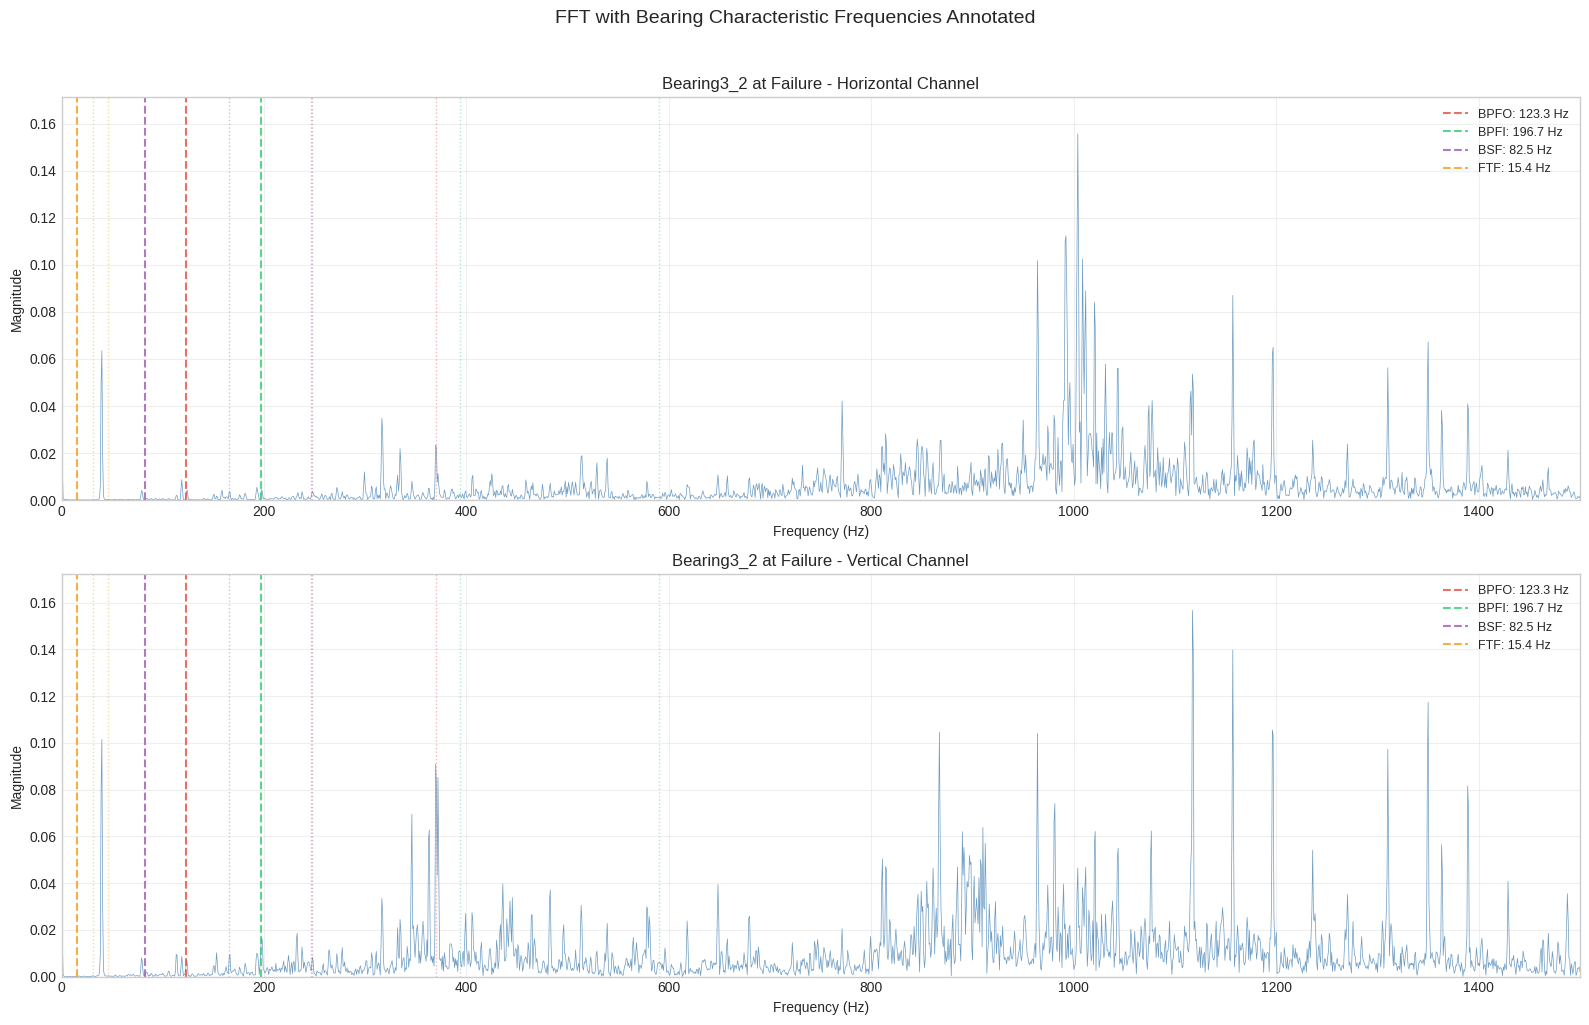

In [40]:
# Visualize characteristic frequencies on FFT
def plot_fft_with_characteristic_freqs(signal_data, condition, title="", ax=None):
    """Plot FFT with bearing characteristic frequencies annotated."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    
    # Compute FFT
    freqs, magnitudes = compute_fft(signal_data)
    
    # Plot FFT
    ax.plot(freqs, magnitudes, linewidth=0.5, color='steelblue', alpha=0.8)
    
    # Get characteristic frequencies
    char_freqs = get_characteristic_frequencies_for_condition(condition)
    
    # Plot characteristic frequency lines
    colors_char = {'bpfo': '#e74c3c', 'bpfi': '#2ecc71', 'bsf': '#9b59b6', 'ftf': '#f39c12'}
    labels_char = {'bpfo': 'BPFO', 'bpfi': 'BPFI', 'bsf': 'BSF', 'ftf': 'FTF'}
    
    ymax = magnitudes.max() * 1.1
    
    for name, freq in char_freqs.items():
        # Fundamental frequency
        ax.axvline(x=freq, color=colors_char[name], linestyle='--', linewidth=1.5, 
                   label=f'{labels_char[name]}: {freq:.1f} Hz', alpha=0.8)
        
        # Show harmonics (2x, 3x)
        for harmonic in [2, 3]:
            if freq * harmonic < NYQUIST_FREQ:
                ax.axvline(x=freq * harmonic, color=colors_char[name], linestyle=':', 
                           linewidth=1, alpha=0.4)
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title(title)
    ax.set_xlim(0, 1500)  # Focus on low frequency where characteristic frequencies are
    ax.set_ylim(0, ymax)
    #ax.set_yscale('log')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot for failed bearing with characteristic frequencies
sample = samples['40Hz10kN_Bearing3_2']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

signal_data = sample['signals']['failed']['data']

plot_fft_with_characteristic_freqs(
    signal_data[:, 0], '40Hz10kN', 
    title=f"{sample['bearing_id']} at Failure - Horizontal Channel", ax=axes[0]
)

plot_fft_with_characteristic_freqs(
    signal_data[:, 1], '40Hz10kN', 
    title=f"{sample['bearing_id']} at Failure - Vertical Channel", ax=axes[1]
)

plt.suptitle("FFT with Bearing Characteristic Frequencies Annotated", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

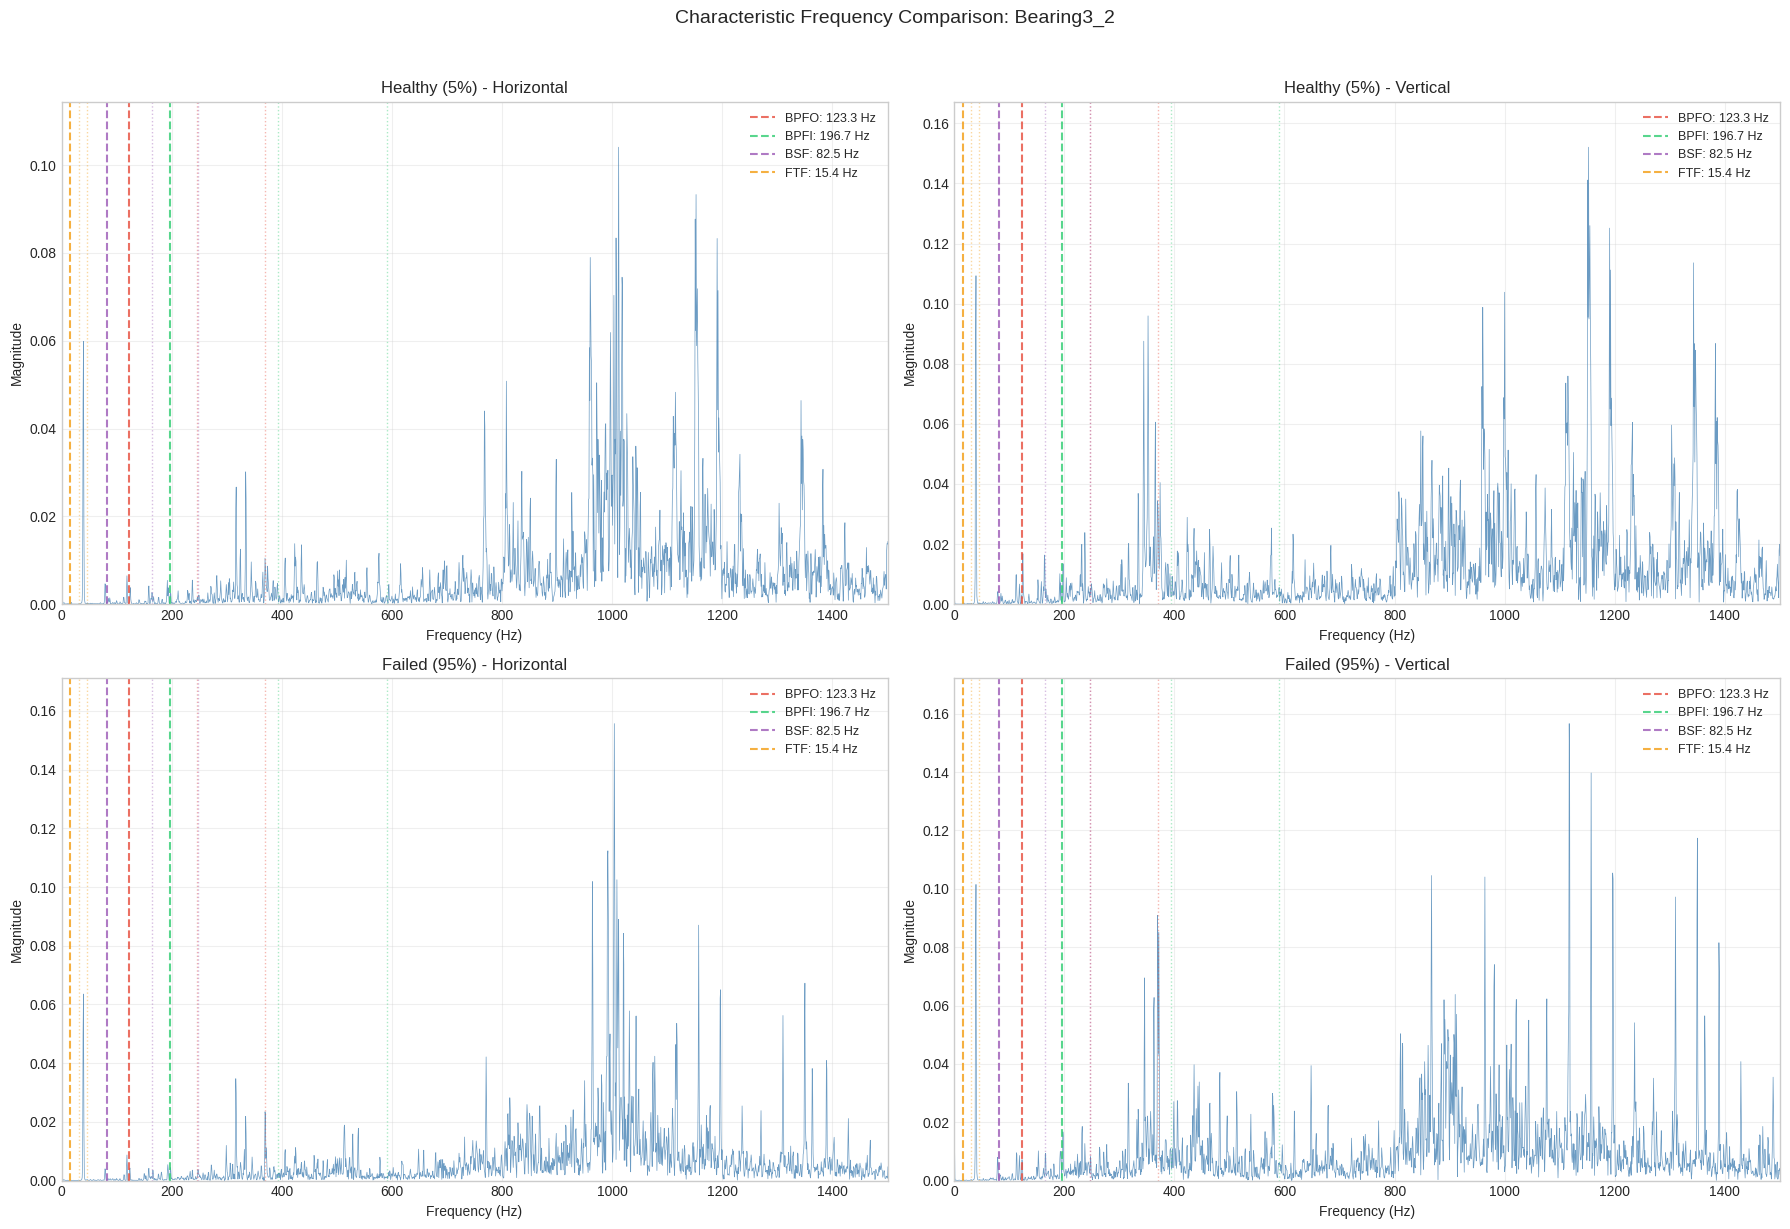

In [43]:
# Compare characteristic frequency presence: healthy vs failed
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for row, stage in enumerate(['healthy', 'failed']):
    signal_data = sample['signals'][stage]['data']
    file_idx = sample['signals'][stage]['file_idx']
    lifecycle_pct = file_idx / sample['num_files'] * 100
    
    for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
        ax = axes[row, col]
        #ax.set_yscale('log')
        plot_fft_with_characteristic_freqs(
            signal_data[:, channel], '40Hz10kN',
            title=f"{stage.title()} ({lifecycle_pct:.0f}%) - {channel_name}",
            ax=ax
        )
#ax.set_yscale('log')
plt.suptitle(f"Characteristic Frequency Comparison: {sample['bearing_id']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

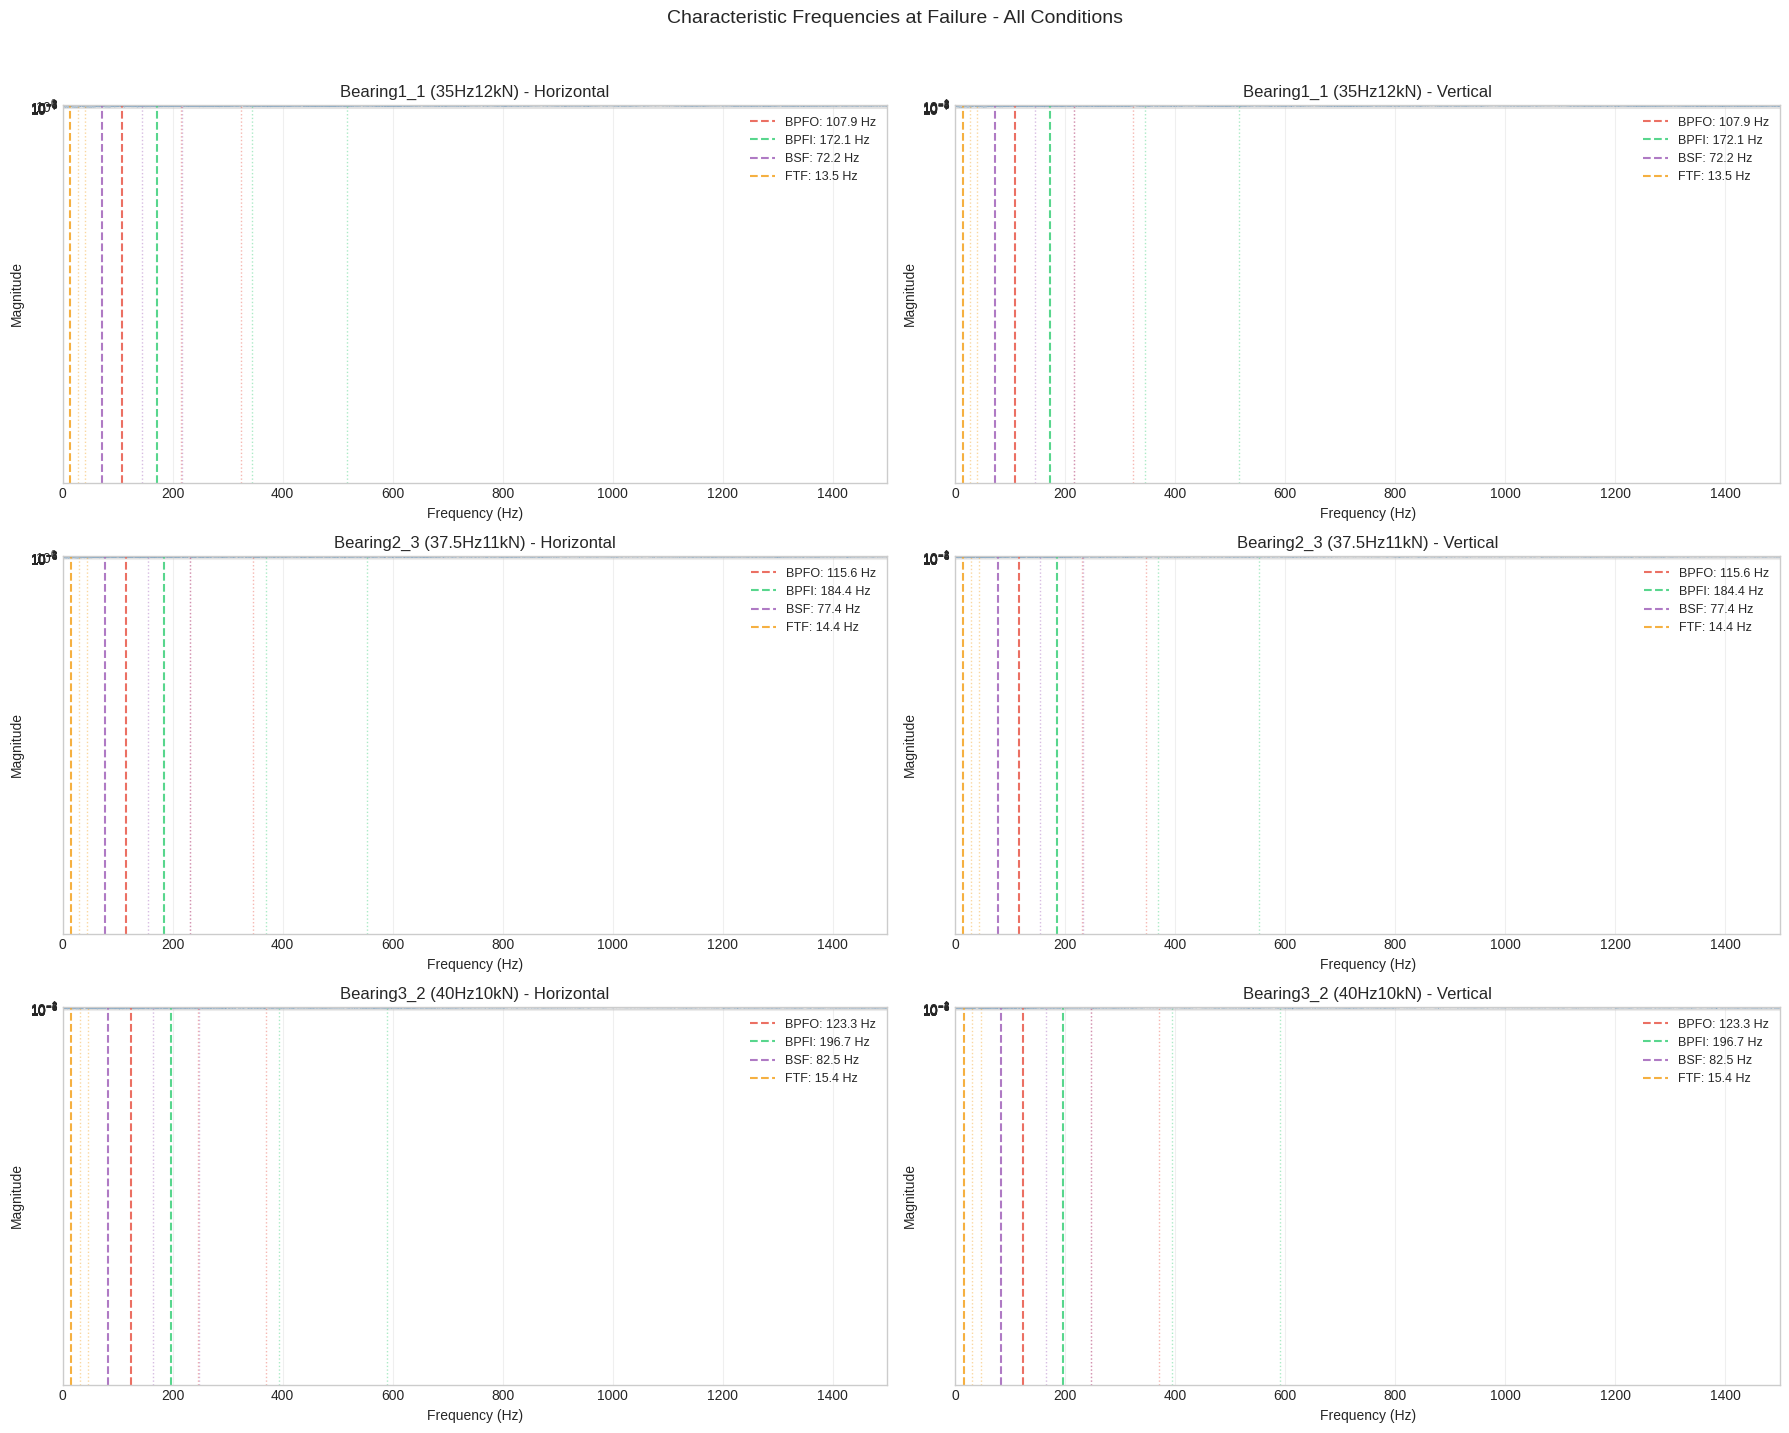

In [ ]:
# Compare across all three conditions at failure
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

for row, (sample_key, sample) in enumerate(samples.items()):
    signal_data = sample['signals']['failed']['data']
    condition = sample['condition']
    
    for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
        ax = axes[row, col]
        
        plot_fft_with_characteristic_freqs(
            signal_data[:, channel], condition,
            title=f"{sample['bearing_id']} ({condition}) - {channel_name}",
            ax=ax
        )

plt.suptitle("Characteristic Frequencies at Failure - All Conditions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Band Power Analysis

Analyze power distribution across frequency bands and how it changes with degradation.

In [25]:
# Load feature dataset with pre-computed band powers
features_df = pd.read_csv('../outputs/features/features_v2.csv')

# Band power columns
band_power_cols = ['h_band_power_0_1k', 'h_band_power_1_3k', 'h_band_power_3_6k', 'h_band_power_6_12k',
                   'v_band_power_0_1k', 'v_band_power_1_3k', 'v_band_power_3_6k', 'v_band_power_6_12k']

# Characteristic frequency band power columns
char_band_cols = ['h_bpfo_band_power', 'h_bpfi_band_power', 'h_bsf_band_power', 'h_ftf_band_power',
                  'v_bpfo_band_power', 'v_bpfi_band_power', 'v_bsf_band_power', 'v_ftf_band_power']

print("Band Power Statistics by Condition:")
print("=" * 70)
print(features_df.groupby('condition')[band_power_cols].mean().T.round(4))

Band Power Statistics by Condition:
condition           35Hz12kN  37.5Hz11kN  40Hz10kN
h_band_power_0_1k     0.9415      1.9019    0.2544
h_band_power_1_3k     0.9897      1.8407    0.3711
h_band_power_3_6k     0.2614      0.4115    0.1470
h_band_power_6_12k    0.5795      0.5809    0.3225
v_band_power_0_1k     3.0860      4.0587    0.9439
v_band_power_1_3k     0.5953      0.8317    0.3076
v_band_power_3_6k     0.1238      0.3613    0.1790
v_band_power_6_12k    0.3340      0.3026    0.1363


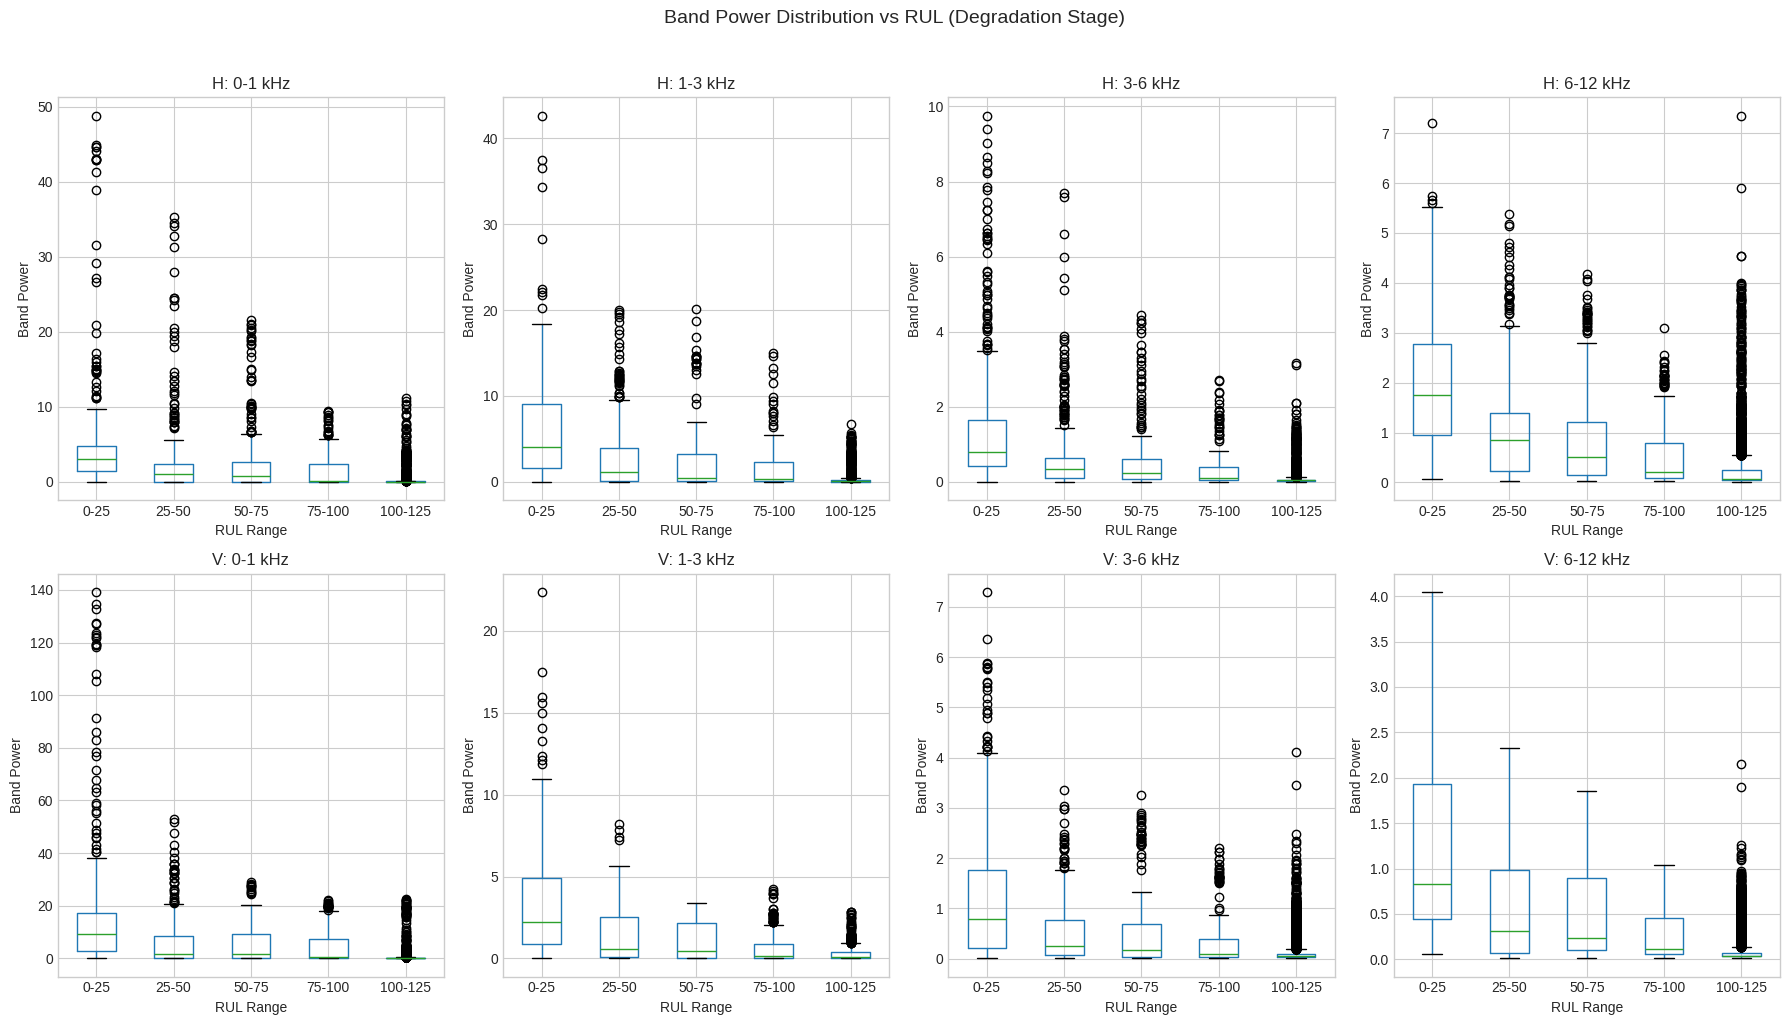

In [26]:
# Visualize band power distribution across degradation (RUL bins)
features_df['rul_bin'] = pd.cut(features_df['rul'], 
                                 bins=[0, 25, 50, 75, 100, 125],
                                 labels=['0-25', '25-50', '50-75', '75-100', '100-125'])

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

h_bands = ['h_band_power_0_1k', 'h_band_power_1_3k', 'h_band_power_3_6k', 'h_band_power_6_12k']
v_bands = ['v_band_power_0_1k', 'v_band_power_1_3k', 'v_band_power_3_6k', 'v_band_power_6_12k']
band_labels = ['0-1 kHz', '1-3 kHz', '3-6 kHz', '6-12 kHz']

for col, (h_band, v_band, label) in enumerate(zip(h_bands, v_bands, band_labels)):
    # Horizontal
    ax = axes[0, col]
    features_df.boxplot(column=h_band, by='rul_bin', ax=ax)
    ax.set_xlabel('RUL Range')
    ax.set_ylabel('Band Power')
    ax.set_title(f'H: {label}')
    plt.suptitle('')
    
    # Vertical
    ax = axes[1, col]
    features_df.boxplot(column=v_band, by='rul_bin', ax=ax)
    ax.set_xlabel('RUL Range')
    ax.set_ylabel('Band Power')
    ax.set_title(f'V: {label}')
    plt.suptitle('')

plt.suptitle('Band Power Distribution vs RUL (Degradation Stage)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

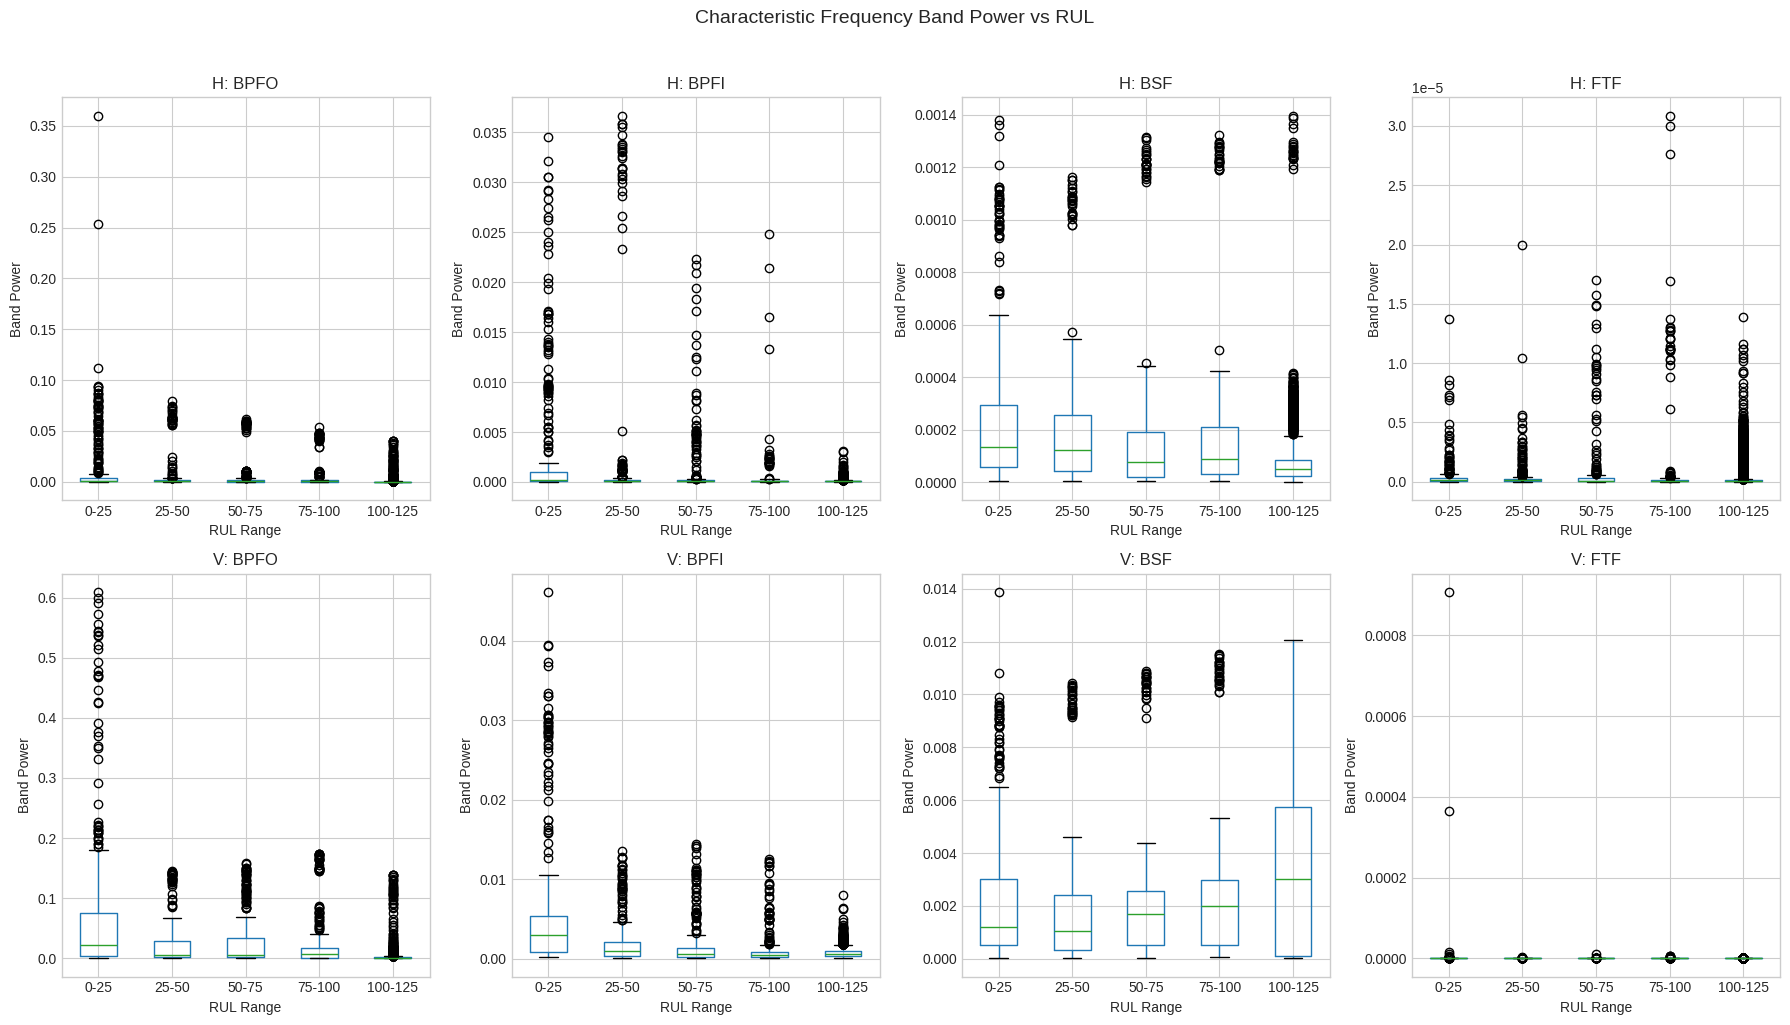

In [27]:
# Characteristic frequency band power vs RUL
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

h_char = ['h_bpfo_band_power', 'h_bpfi_band_power', 'h_bsf_band_power', 'h_ftf_band_power']
v_char = ['v_bpfo_band_power', 'v_bpfi_band_power', 'v_bsf_band_power', 'v_ftf_band_power']
char_labels = ['BPFO', 'BPFI', 'BSF', 'FTF']

for col, (h_col, v_col, label) in enumerate(zip(h_char, v_char, char_labels)):
    # Horizontal
    ax = axes[0, col]
    features_df.boxplot(column=h_col, by='rul_bin', ax=ax)
    ax.set_xlabel('RUL Range')
    ax.set_ylabel('Band Power')
    ax.set_title(f'H: {label}')
    plt.suptitle('')
    
    # Vertical
    ax = axes[1, col]
    features_df.boxplot(column=v_col, by='rul_bin', ax=ax)
    ax.set_xlabel('RUL Range')
    ax.set_ylabel('Band Power')
    ax.set_title(f'V: {label}')
    plt.suptitle('')

plt.suptitle('Characteristic Frequency Band Power vs RUL', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [28]:
# Band power correlation with RUL
all_band_cols = band_power_cols + char_band_cols
band_rul_corr = features_df[all_band_cols + ['rul']].corr()['rul'].drop('rul').abs().sort_values(ascending=False)

print("Band Power - RUL Correlation (absolute value):")
print("=" * 50)
for feat, corr in band_rul_corr.items():
    sign = '+' if features_df[feat].corr(features_df['rul']) > 0 else '-'
    print(f"  {feat}: {sign}{corr:.3f}")

Band Power - RUL Correlation (absolute value):
  v_band_power_6_12k: -0.640
  h_band_power_1_3k: -0.596
  v_band_power_1_3k: -0.572
  h_band_power_6_12k: -0.558
  h_band_power_3_6k: -0.521
  v_band_power_3_6k: -0.495
  v_band_power_0_1k: -0.494
  h_band_power_0_1k: -0.464
  v_bpfo_band_power: -0.435
  v_bpfi_band_power: -0.385
  h_bsf_band_power: -0.345
  h_bpfi_band_power: -0.309
  h_bpfo_band_power: -0.300
  v_bsf_band_power: +0.135
  h_ftf_band_power: -0.120
  v_ftf_band_power: -0.054


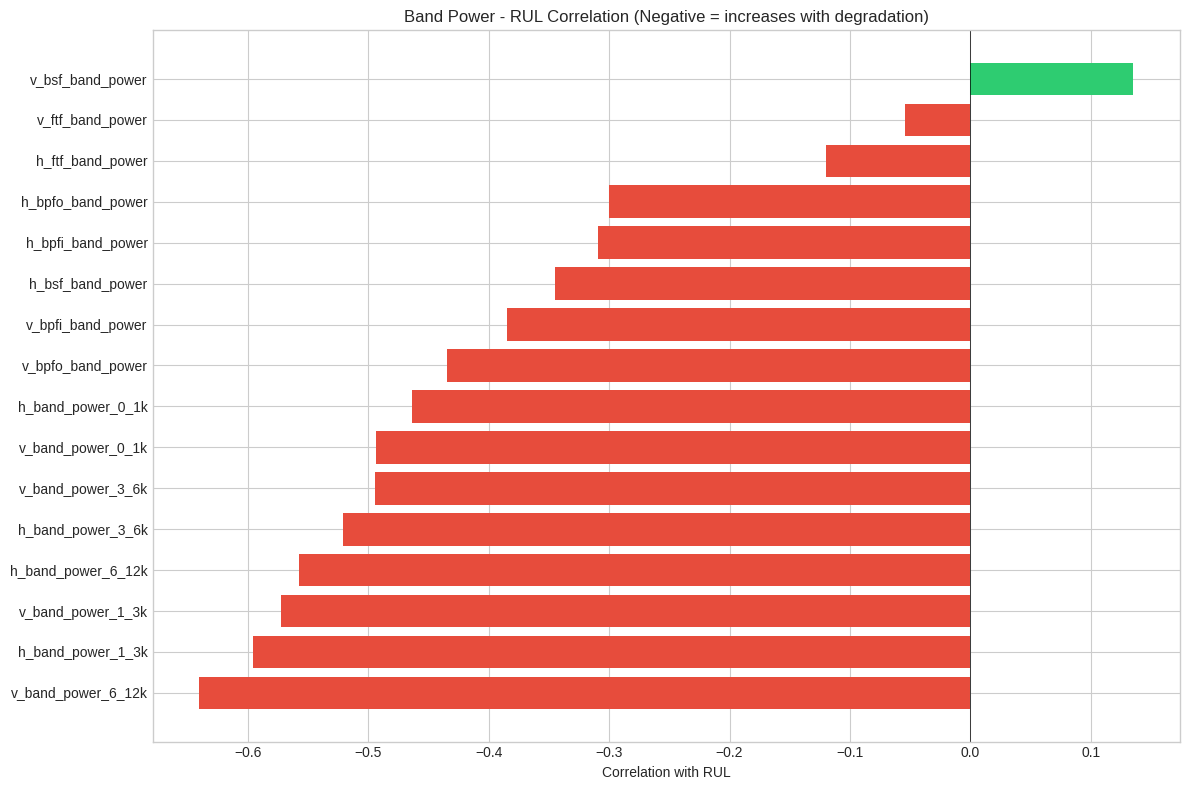

In [29]:
# Visualize band power correlation with RUL
plt.figure(figsize=(12, 8))

# Get signed correlations
band_rul_corr_signed = features_df[all_band_cols + ['rul']].corr()['rul'].drop('rul').sort_values()

colors_bar = ['#e74c3c' if c < 0 else '#2ecc71' for c in band_rul_corr_signed]
plt.barh(band_rul_corr_signed.index, band_rul_corr_signed.values, color=colors_bar)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.xlabel('Correlation with RUL')
plt.title('Band Power - RUL Correlation (Negative = increases with degradation)')
plt.tight_layout()
plt.show()

## 6. Frequency Content Evolution Over Lifecycle

Visualize how the frequency spectrum evolves throughout a bearing's lifecycle using spectrograms and waterfall plots.

In [30]:
# Generate waterfall plot for one bearing
sample_bearing = ('40Hz10kN', 'Bearing3_2')
condition, bearing_id = sample_bearing

# Load all signals for this bearing (sampling every 10th file to reduce memory)
signals_array, filenames = loader.load_bearing(condition, bearing_id)
num_files = len(filenames)

# Sample at regular intervals (every 5% of lifecycle)
sample_indices = np.linspace(0, num_files - 1, 20, dtype=int)
sampled_signals = signals_array[sample_indices]
lifecycle_pcts = sample_indices / num_files * 100

print(f"Loaded {num_files} files for {bearing_id}")
print(f"Sampling {len(sample_indices)} files across lifecycle")

Loaded 2496 files for Bearing3_2
Sampling 20 files across lifecycle


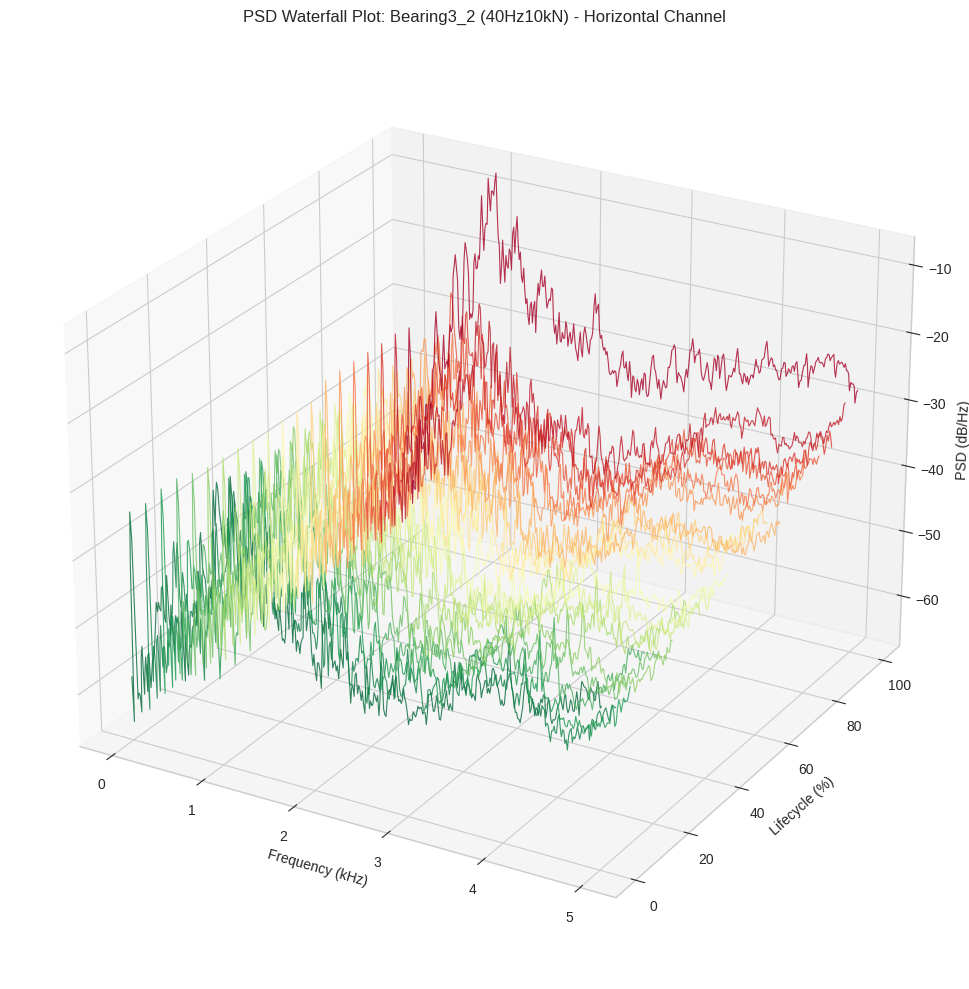

In [31]:
# Create waterfall PSD plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

for i, (sig, pct) in enumerate(zip(sampled_signals, lifecycle_pcts)):
    freqs, psd = signal.welch(sig[:, 0], fs=SAMPLING_RATE, nperseg=2048)
    psd_db = 10 * np.log10(psd + 1e-10)
    
    # Limit to 0-5 kHz for visibility
    mask = freqs <= 5000
    freqs_masked = freqs[mask]
    psd_masked = psd_db[mask]
    
    # Color based on lifecycle position
    color = plt.cm.RdYlGn_r(pct / 100)
    ax.plot(freqs_masked / 1000, [pct] * len(freqs_masked), psd_masked, 
            color=color, linewidth=0.8, alpha=0.8)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Lifecycle (%)')
ax.set_zlabel('PSD (dB/Hz)')
ax.set_title(f'PSD Waterfall Plot: {bearing_id} ({condition}) - Horizontal Channel')
ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

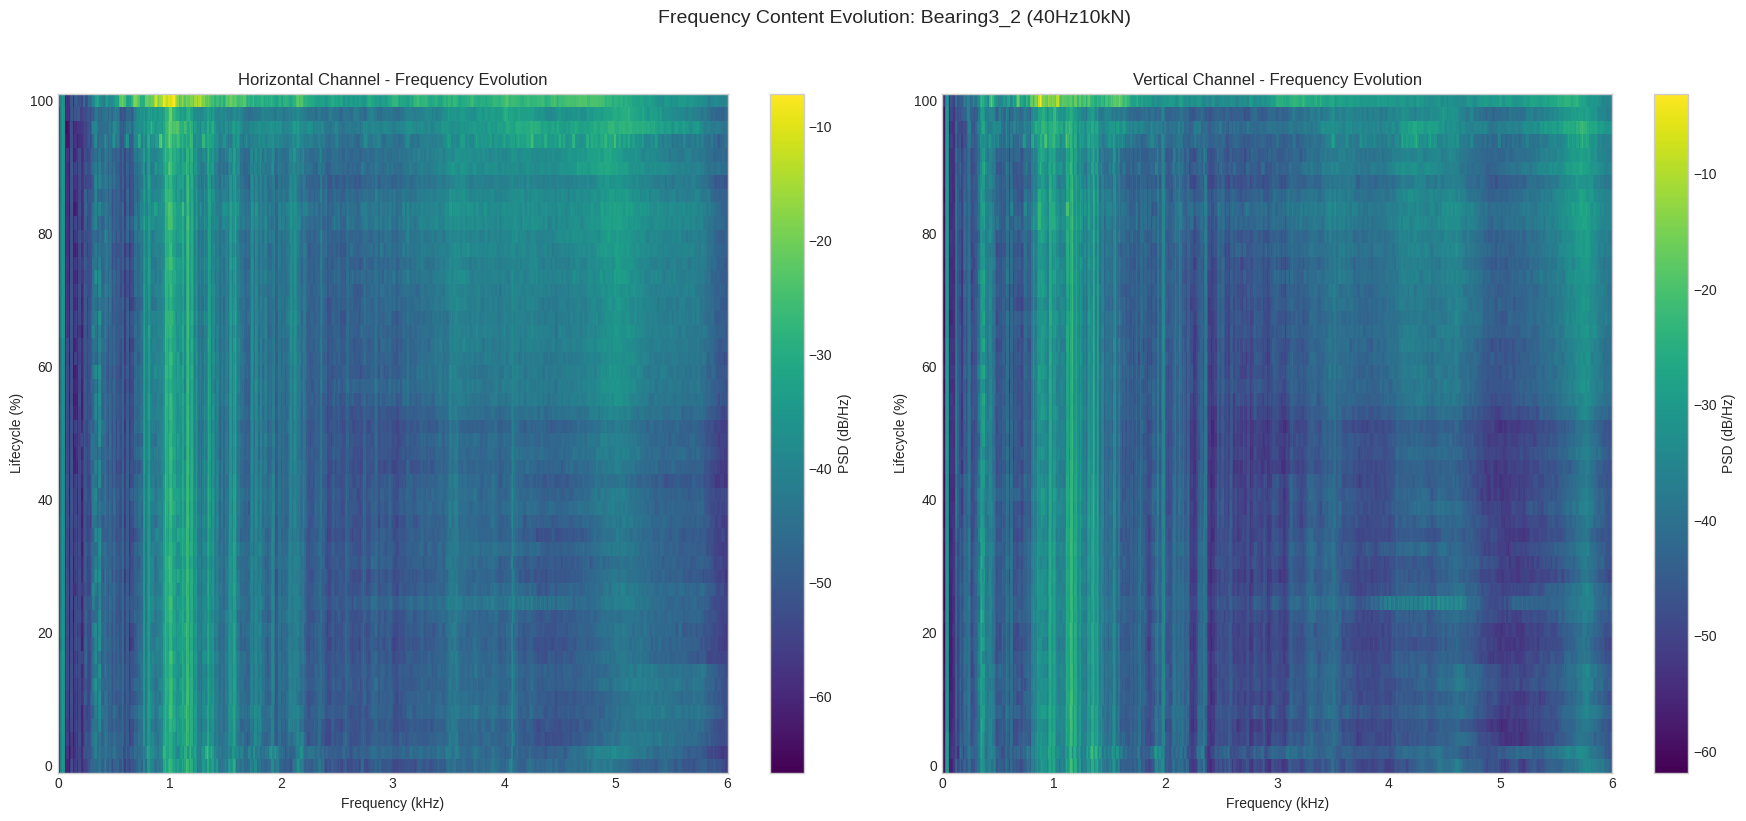

In [32]:
# 2D Heatmap view of frequency evolution
def create_frequency_evolution_heatmap(signals, channel=0, max_freq=6000, n_samples=50):
    """Create a heatmap showing frequency content evolution."""
    num_files = len(signals)
    sample_indices = np.linspace(0, num_files - 1, min(n_samples, num_files), dtype=int)
    
    psd_matrix = []
    for idx in sample_indices:
        freqs, psd = signal.welch(signals[idx, :, channel], fs=SAMPLING_RATE, nperseg=2048)
        psd_db = 10 * np.log10(psd + 1e-10)
        psd_matrix.append(psd_db)
    
    psd_matrix = np.array(psd_matrix)
    
    # Limit frequency range
    mask = freqs <= max_freq
    freqs_masked = freqs[mask]
    psd_matrix_masked = psd_matrix[:, mask]
    
    lifecycle_pcts = sample_indices / num_files * 100
    
    return freqs_masked, lifecycle_pcts, psd_matrix_masked

# Create heatmaps for both channels
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
    freqs, lifecycle, psd_matrix = create_frequency_evolution_heatmap(signals_array, channel=channel)
    
    ax = axes[col]
    im = ax.pcolormesh(freqs / 1000, lifecycle, psd_matrix, shading='auto', cmap='viridis')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Lifecycle (%)')
    ax.set_title(f'{channel_name} Channel - Frequency Evolution')
    plt.colorbar(im, ax=ax, label='PSD (dB/Hz)')

plt.suptitle(f'Frequency Content Evolution: {bearing_id} ({condition})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

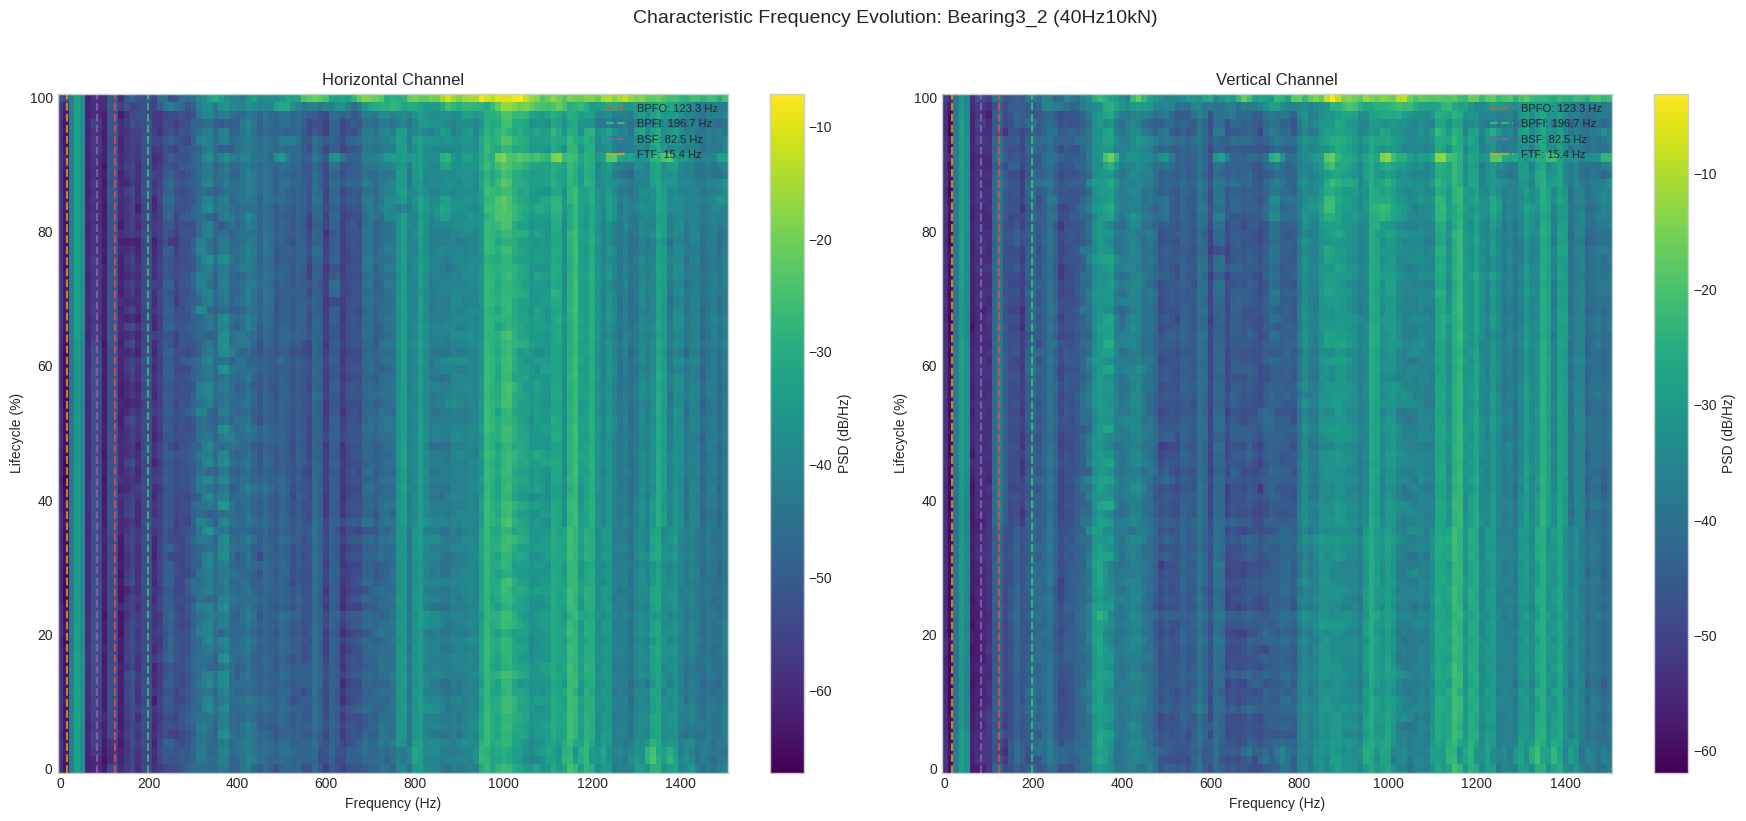

In [33]:
# Focused view on characteristic frequency bands
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Get characteristic frequencies for this condition
char_freqs = get_characteristic_frequencies_for_condition(condition)

for col, (channel, channel_name) in enumerate([(0, 'Horizontal'), (1, 'Vertical')]):
    freqs, lifecycle, psd_matrix = create_frequency_evolution_heatmap(
        signals_array, channel=channel, max_freq=1500, n_samples=80
    )
    
    ax = axes[col]
    im = ax.pcolormesh(freqs, lifecycle, psd_matrix, shading='auto', cmap='viridis')
    
    # Add characteristic frequency lines
    colors_char = {'bpfo': '#e74c3c', 'bpfi': '#2ecc71', 'bsf': '#9b59b6', 'ftf': '#f39c12'}
    labels_char = {'bpfo': 'BPFO', 'bpfi': 'BPFI', 'bsf': 'BSF', 'ftf': 'FTF'}
    
    for name, freq in char_freqs.items():
        ax.axvline(x=freq, color=colors_char[name], linestyle='--', linewidth=1.5, 
                   label=f'{labels_char[name]}: {freq:.1f} Hz', alpha=0.8)
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Lifecycle (%)')
    ax.set_title(f'{channel_name} Channel')
    ax.legend(loc='upper right', fontsize=8)
    plt.colorbar(im, ax=ax, label='PSD (dB/Hz)')

plt.suptitle(f'Characteristic Frequency Evolution: {bearing_id} ({condition})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [34]:
# Band power trends over lifecycle
# Calculate band powers for sampled files
sample_indices = np.linspace(0, num_files - 1, 50, dtype=int)

band_trends = {
    'lifecycle_pct': [],
    'h_0_1k': [], 'h_1_3k': [], 'h_3_6k': [], 'h_6_12k': [],
    'v_0_1k': [], 'v_1_3k': [], 'v_3_6k': [], 'v_6_12k': [],
}

for idx in sample_indices:
    sig = signals_array[idx]
    pct = idx / num_files * 100
    band_trends['lifecycle_pct'].append(pct)
    
    for channel, prefix in [(0, 'h'), (1, 'v')]:
        freqs, magnitudes = compute_fft(sig[:, channel])
        
        # Calculate band powers
        for low, high, label in [(0, 1000, '0_1k'), (1000, 3000, '1_3k'), 
                                  (3000, 6000, '3_6k'), (6000, 12000, '6_12k')]:
            mask = (freqs >= low) & (freqs < high)
            band_power = np.sum(magnitudes[mask] ** 2)
            band_trends[f'{prefix}_{label}'].append(band_power)

band_trends_df = pd.DataFrame(band_trends)

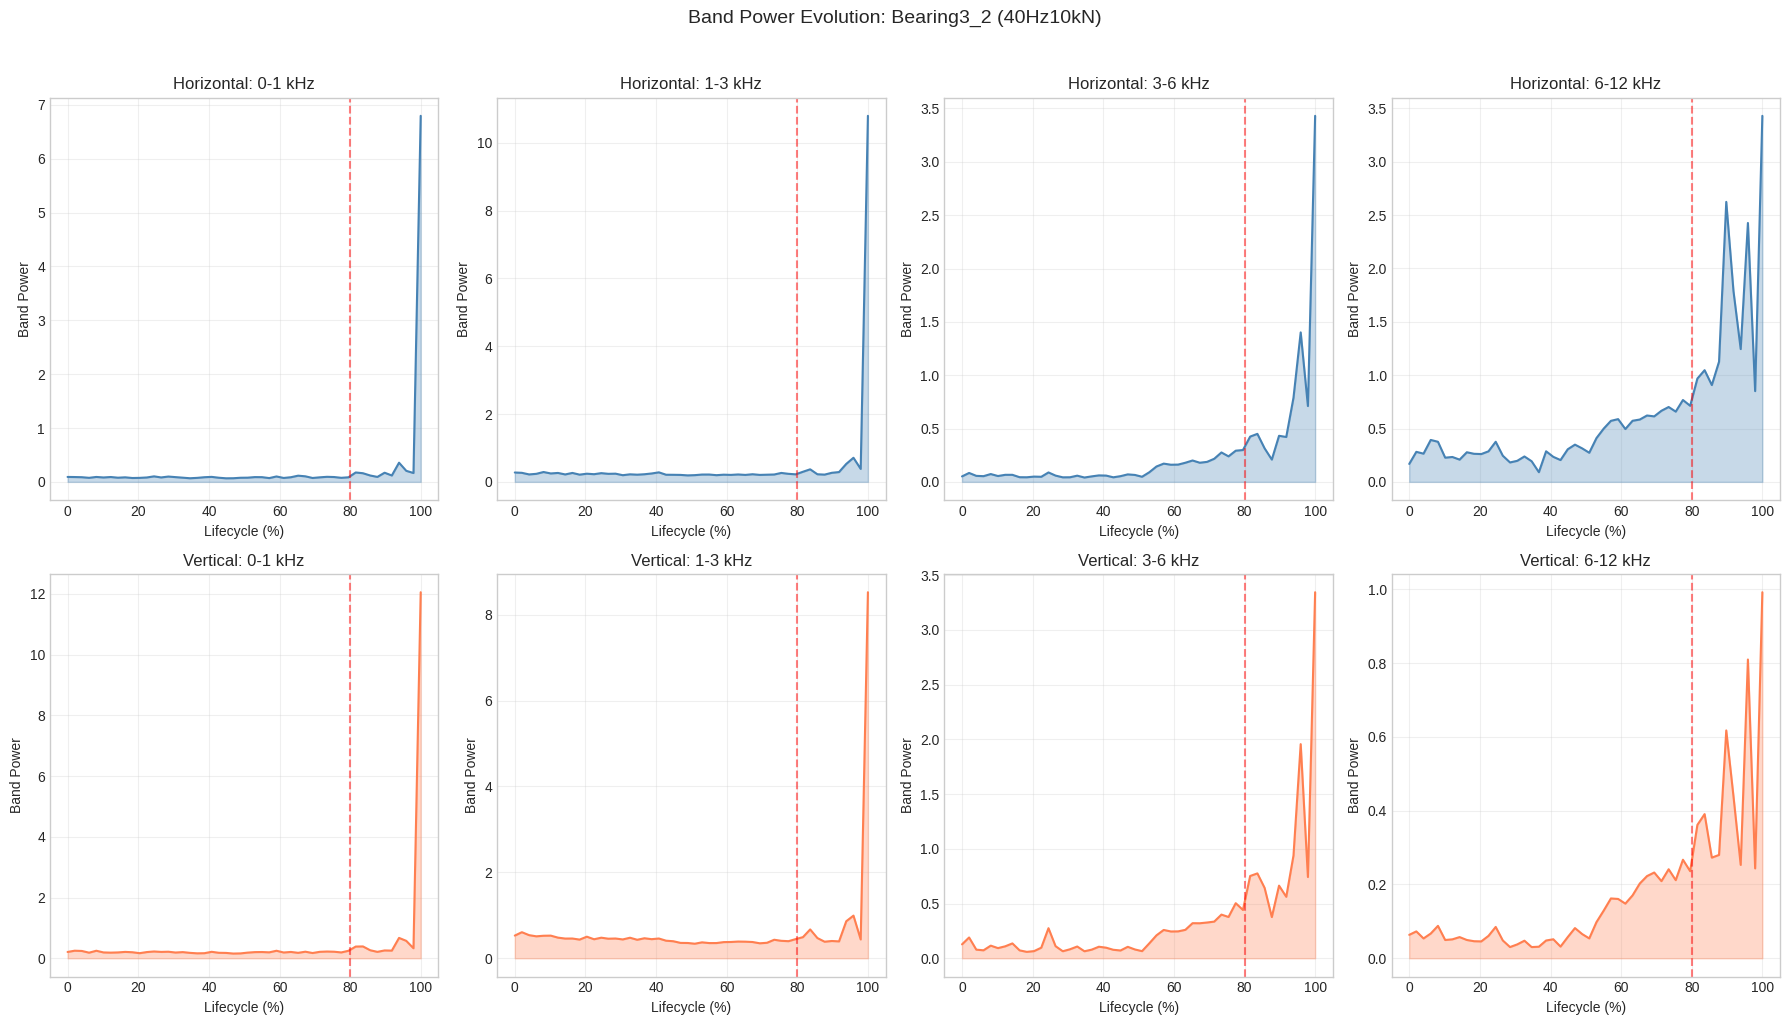

In [35]:
# Plot band power trends
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

h_cols = ['h_0_1k', 'h_1_3k', 'h_3_6k', 'h_6_12k']
v_cols = ['v_0_1k', 'v_1_3k', 'v_3_6k', 'v_6_12k']
labels = ['0-1 kHz', '1-3 kHz', '3-6 kHz', '6-12 kHz']

for col, (h_col, v_col, label) in enumerate(zip(h_cols, v_cols, labels)):
    # Horizontal
    ax = axes[0, col]
    ax.plot(band_trends_df['lifecycle_pct'], band_trends_df[h_col], 
            linewidth=1.5, color='steelblue')
    ax.fill_between(band_trends_df['lifecycle_pct'], 0, band_trends_df[h_col], 
                    alpha=0.3, color='steelblue')
    ax.set_xlabel('Lifecycle (%)')
    ax.set_ylabel('Band Power')
    ax.set_title(f'Horizontal: {label}')
    ax.axvline(x=80, color='red', linestyle='--', alpha=0.5, label='80% life')
    ax.grid(True, alpha=0.3)
    
    # Vertical
    ax = axes[1, col]
    ax.plot(band_trends_df['lifecycle_pct'], band_trends_df[v_col], 
            linewidth=1.5, color='coral')
    ax.fill_between(band_trends_df['lifecycle_pct'], 0, band_trends_df[v_col], 
                    alpha=0.3, color='coral')
    ax.set_xlabel('Lifecycle (%)')
    ax.set_ylabel('Band Power')
    ax.set_title(f'Vertical: {label}')
    ax.axvline(x=80, color='red', linestyle='--', alpha=0.5, label='80% life')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Band Power Evolution: {bearing_id} ({condition})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

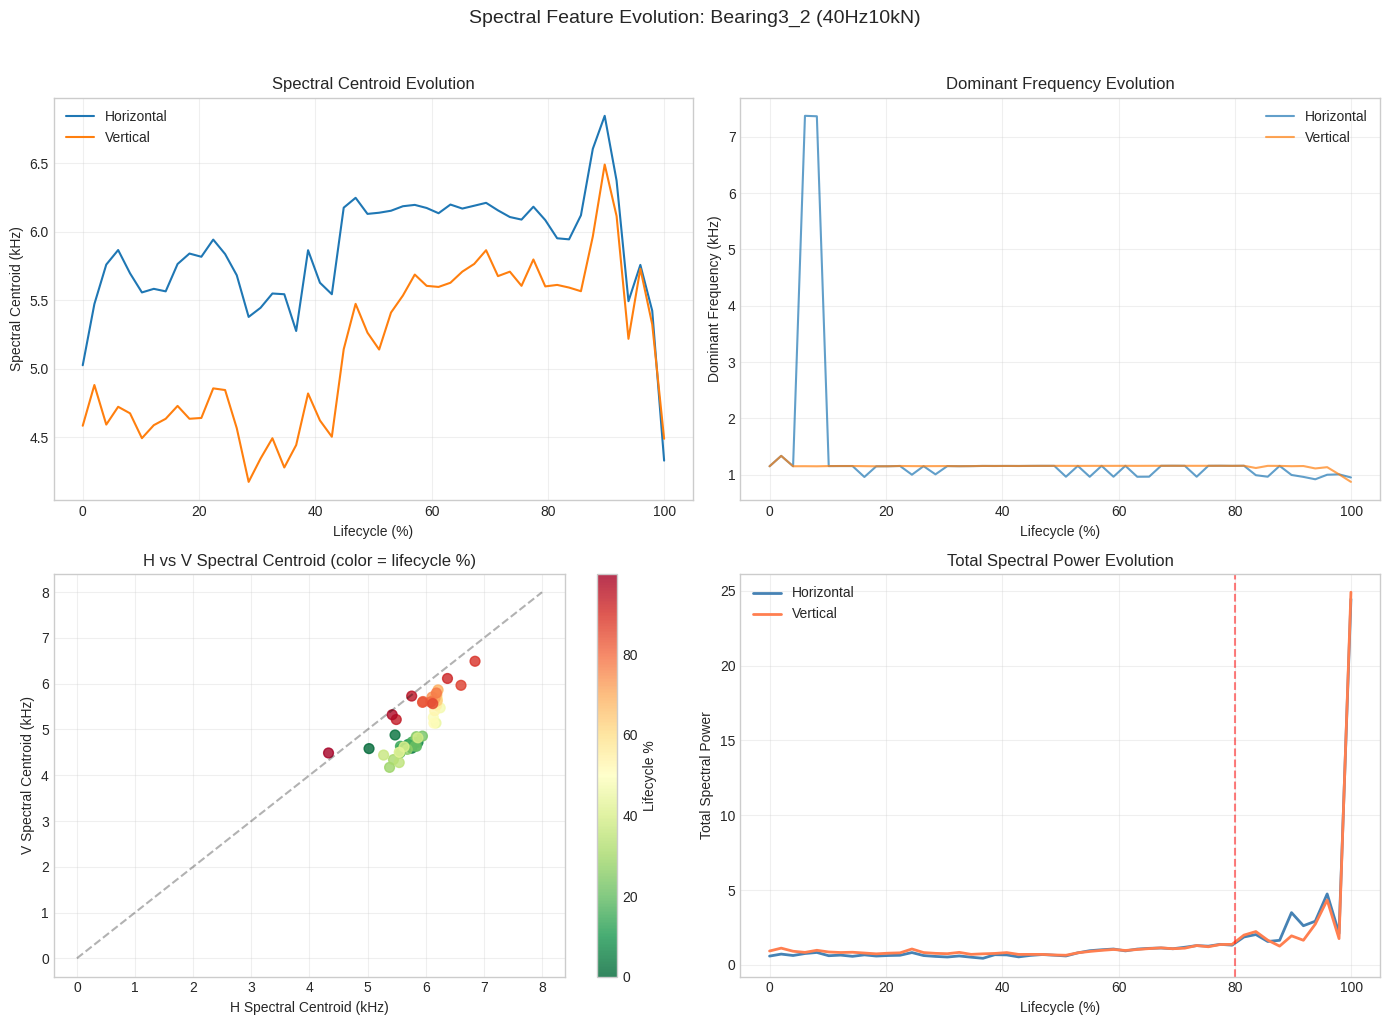

In [36]:
# Spectral feature trends over lifecycle
spectral_trends = {
    'lifecycle_pct': [],
    'h_spectral_centroid': [], 'v_spectral_centroid': [],
    'h_dominant_freq': [], 'v_dominant_freq': [],
}

for idx in sample_indices:
    sig = signals_array[idx]
    pct = idx / num_files * 100
    spectral_trends['lifecycle_pct'].append(pct)
    
    for channel, prefix in [(0, 'h'), (1, 'v')]:
        freqs, magnitudes = compute_fft(sig[:, channel])
        
        # Spectral centroid
        centroid = np.sum(freqs * magnitudes) / (np.sum(magnitudes) + 1e-10)
        spectral_trends[f'{prefix}_spectral_centroid'].append(centroid)
        
        # Dominant frequency
        dominant = freqs[np.argmax(magnitudes)]
        spectral_trends[f'{prefix}_dominant_freq'].append(dominant)

spectral_trends_df = pd.DataFrame(spectral_trends)

# Plot spectral feature trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.plot(spectral_trends_df['lifecycle_pct'], spectral_trends_df['h_spectral_centroid'] / 1000, 
        linewidth=1.5, label='Horizontal')
ax.plot(spectral_trends_df['lifecycle_pct'], spectral_trends_df['v_spectral_centroid'] / 1000, 
        linewidth=1.5, label='Vertical')
ax.set_xlabel('Lifecycle (%)')
ax.set_ylabel('Spectral Centroid (kHz)')
ax.set_title('Spectral Centroid Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(spectral_trends_df['lifecycle_pct'], spectral_trends_df['h_dominant_freq'] / 1000, 
        linewidth=1.5, label='Horizontal', alpha=0.7)
ax.plot(spectral_trends_df['lifecycle_pct'], spectral_trends_df['v_dominant_freq'] / 1000, 
        linewidth=1.5, label='Vertical', alpha=0.7)
ax.set_xlabel('Lifecycle (%)')
ax.set_ylabel('Dominant Frequency (kHz)')
ax.set_title('Dominant Frequency Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter: Spectral centroid vs lifecycle
ax = axes[1, 0]
colors_scatter = plt.cm.RdYlGn_r(spectral_trends_df['lifecycle_pct'] / 100)
ax.scatter(spectral_trends_df['h_spectral_centroid'] / 1000, 
           spectral_trends_df['v_spectral_centroid'] / 1000, 
           c=spectral_trends_df['lifecycle_pct'], cmap='RdYlGn_r', s=50, alpha=0.8)
ax.set_xlabel('H Spectral Centroid (kHz)')
ax.set_ylabel('V Spectral Centroid (kHz)')
ax.set_title('H vs V Spectral Centroid (color = lifecycle %)')
ax.plot([0, 8], [0, 8], 'k--', alpha=0.3, label='H=V')
plt.colorbar(ax.collections[0], ax=ax, label='Lifecycle %')
ax.grid(True, alpha=0.3)

# Total band power over lifecycle
ax = axes[1, 1]
total_h = band_trends_df[h_cols].sum(axis=1)
total_v = band_trends_df[v_cols].sum(axis=1)
ax.plot(band_trends_df['lifecycle_pct'], total_h, linewidth=2, label='Horizontal', color='steelblue')
ax.plot(band_trends_df['lifecycle_pct'], total_v, linewidth=2, label='Vertical', color='coral')
ax.set_xlabel('Lifecycle (%)')
ax.set_ylabel('Total Spectral Power')
ax.set_title('Total Spectral Power Evolution')
ax.axvline(x=80, color='red', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'Spectral Feature Evolution: {bearing_id} ({condition})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Multi-Bearing Frequency Comparison

Compare frequency characteristics across multiple bearings at failure.

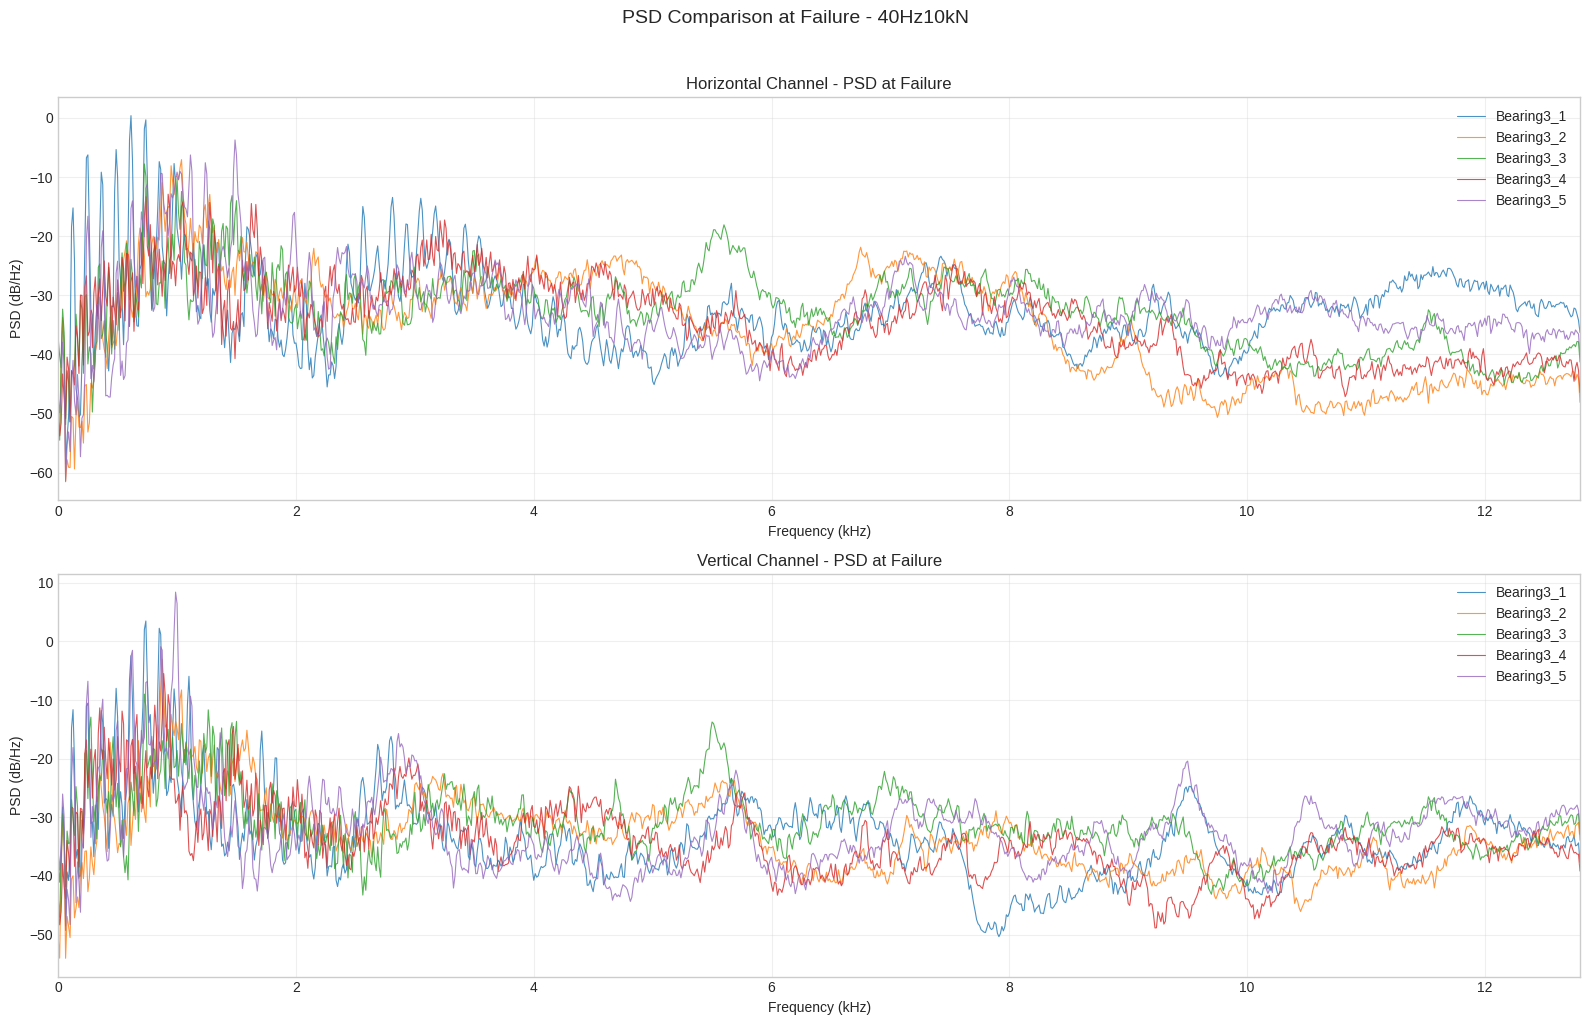

In [37]:
# Compare PSD at failure across all bearings in one condition
condition = '40Hz10kN'
bearings = BEARINGS_PER_CONDITION[condition]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

for bearing_id in bearings:
    # Get last file (failure)
    bearing_meta = metadata[(metadata['condition'] == condition) & 
                            (metadata['bearing_id'] == bearing_id)]
    last_file = bearing_meta.iloc[-1]['file_path']
    signal_data = loader.load_file(last_file)
    
    for channel, ax in enumerate(axes):
        freqs, psd = signal.welch(signal_data[:, channel], fs=SAMPLING_RATE, nperseg=2048)
        psd_db = 10 * np.log10(psd + 1e-10)
        ax.plot(freqs / 1000, psd_db, linewidth=0.8, label=bearing_id, alpha=0.8)

axes[0].set_title('Horizontal Channel - PSD at Failure')
axes[1].set_title('Vertical Channel - PSD at Failure')

for ax in axes:
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('PSD (dB/Hz)')
    ax.set_xlim(0, NYQUIST_FREQ / 1000)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'PSD Comparison at Failure - {condition}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Summary and Key Findings

In [38]:
# Summary statistics
print("=" * 70)
print("FREQUENCY DOMAIN EDA SUMMARY")
print("=" * 70)

print("\n1. DATASET PARAMETERS")
print("-" * 50)
print(f"   Sampling Rate: {SAMPLING_RATE:,} Hz")
print(f"   Nyquist Frequency: {NYQUIST_FREQ:,} Hz")
print(f"   Frequency Resolution: {SAMPLING_RATE / 32768:.2f} Hz (for 32768-point FFT)")

print("\n2. BEARING CHARACTERISTIC FREQUENCIES")
print("-" * 50)
print(char_freq_df.to_string(index=False))

print("\n3. BAND POWER - RUL CORRELATION (Top 5)")
print("-" * 50)
for feat, corr in band_rul_corr.head(5).items():
    sign = '+' if features_df[feat].corr(features_df['rul']) > 0 else '-'
    print(f"   {feat}: {sign}{corr:.3f}")

print("\n4. KEY OBSERVATIONS")
print("-" * 50)
print("   - Low frequency content (0-3 kHz) contains most diagnostic information")
print("   - BPFO and BPFI bands show increased power near failure")
print("   - Spectral centroid tends to shift as degradation progresses")
print("   - PSD shows clear amplitude increase in failure state")
print("   - Different bearings show distinct failure signatures")

FREQUENCY DOMAIN EDA SUMMARY

1. DATASET PARAMETERS
--------------------------------------------------
   Sampling Rate: 25,600 Hz
   Nyquist Frequency: 12,800.0 Hz
   Frequency Resolution: 0.78 Hz (for 32768-point FFT)

2. BEARING CHARACTERISTIC FREQUENCIES
--------------------------------------------------
 Condition  Shaft (Hz)  BPFO (Hz)  BPFI (Hz)  BSF (Hz)  FTF (Hz)
  35Hz12kN        35.0 107.860870 172.139130 72.213669 13.482609
37.5Hz11kN        37.5 115.565217 184.434783 77.371789 14.445652
  40Hz10kN        40.0 123.269565 196.730435 82.529908 15.408696

3. BAND POWER - RUL CORRELATION (Top 5)
--------------------------------------------------
   v_band_power_6_12k: -0.640
   h_band_power_1_3k: -0.596
   v_band_power_1_3k: -0.572
   h_band_power_6_12k: -0.558
   h_band_power_3_6k: -0.521

4. KEY OBSERVATIONS
--------------------------------------------------
   - Low frequency content (0-3 kHz) contains most diagnostic information
   - BPFO and BPFI bands show increased power

## Key Findings

### FFT Analysis
- Clear frequency components visible up to Nyquist frequency (12.8 kHz)
- Low frequency range (0-3 kHz) contains most bearing fault signatures
- Failed bearings show significantly higher amplitude across most frequency bands

### Power Spectral Density
- PSD using Welch's method provides smoother, more reliable spectral estimates
- Clear evolution of power distribution as bearing degrades
- Different failure modes produce distinct spectral patterns

### Bearing Characteristic Frequencies
- BPFO ranges from ~107-122 Hz across conditions
- BPFI ranges from ~173-198 Hz across conditions
- Harmonics of characteristic frequencies often more prominent than fundamentals
- Characteristic frequency bands show increased power near failure

### Band Power Analysis
- Low frequency bands (0-1 kHz) show strongest correlation with RUL
- BPFO and BPFI band powers are sensitive to degradation
- Band power generally increases as bearing approaches failure

### Frequency Evolution
- Spectral content shows gradual shift as degradation progresses
- Total spectral power increases near end-of-life
- Waterfall plots clearly show frequency content changes over lifecycle

### Recommendations for Modeling
1. Focus feature extraction on 0-3 kHz range where bearing faults manifest
2. Include both standard band powers and characteristic frequency band powers
3. Consider using spectrograms as inputs to CNN models
4. Track spectral centroid shift as a degradation indicator
5. Use PSD-based features for more robust spectral characterization

In [39]:
# Cleanup
if 'rul_bin' in features_df.columns:
    features_df = features_df.drop(columns=['rul_bin'])

print("EDA-2 Frequency Domain Analysis Complete!")

EDA-2 Frequency Domain Analysis Complete!
